<!-- # Análisis Exploratorio de Datos (EDA) - Predicción de Salarios

Este notebook realiza el análisis exploratorio de los datos para y desafío de predicción de salarios, con el objetivo de comprender la estructura, calidad y patrones presentes en los datos. Posteriormente, en la fase de modelado, se plantea un modelo baseline con varios tipos de regresión, en la ultima etapa se plantean modelos mas complejos a fin de superarlo.


## 📑 Indice.

1. [**Configuración Inicial**](##1-configuración-inicial)
   - Importación de librerías
   - Configuración del entorno

2. [**Carga de Datos**](01_eda.ipynb#2-carga-de-datos)
   - Carga de los datasets originales
   - Verificación de integridad de datos

3. [**Validación de Integridad**](#3-validación-de-integridad)
   - Verificación de IDs comunes
   - Join de las tablas

4. [**Análisis de Calidad de Datos**](#4-análisis-de-calidad-de-datos)
   - Identificación de valores nulos
   - Análisis de registros inconsistentes

5. [**Limpieza y Tratamiento de Datos**](#5-limpieza-y-tratamiento-de-datos)
   - Estrategias de imputación
   - Eliminación de registros irrelevantes
   - Corrección manual de inconsistencias

6. [**Análisis Descriptivo**](#6-análisis-descriptivo)
   - Estadísticas descriptivas
   - Distribuciones de variables
   - Análisis de correlaciones

7. [**Conclusiones del análisis exploratorio**](#7-conclusiones-y-insights)
   - Hallazgos principales
   - Recomendaciones para modelado

8. [**Feature Engineering**](#8-Feature-Engineering)
   - En base a variables numericas.
   - En base a variables categóricas.
   - Utilizando llama para el job_title.


--- -->

#

# Análisis Exploratorio de Datos (EDA) - Predicción de Salarios

Este notebook realiza el análisis exploratorio de los datos para el desafío de predicción de salarios, con el objetivo de comprender la estructura, calidad y patrones presentes en los datos. Posteriormente, en la fase de modelado, se plantea un modelo baseline con varios tipos de regresión, y en la última etapa se plantean modelos más complejos a fin de superarlo.

## 📑 Índice

1. [**Configuración Inicial**](#1-configuración-inicial)
   - Importación de librerías
   - Configuración del entorno

2. [**Carga de Datos**](#2-carga-de-datos)
   - Carga de los datasets originales
   - Verificación de integridad de datos

3. [**Validación de Integridad**](#3-validación-de-integridad)
   - Verificación de IDs comunes
   - Unificar los datasets

4. [**Análisis de Calidad de Datos**](#4-análisis-de-calidad-de-datos)
   - Identificación de valores nulos
   - Análisis de registros inconsistentes

5. [**Limpieza y Tratamiento de Datos**](#5-limpieza-y-tratamiento-de-datos)
   - Estrategias de imputación
   - Corrección de inconsistencias detectadas

6. [**Análisis Descriptivo**](#6-análisis-descriptivo)
   - Estadísticas descriptivas generales
   - Análisis específico de salarios
   - Análisis de variables categóricas
   - Análisis de correlaciones

7. [**Conclusiones e Insights**](#7-conclusiones-e-insights)
   - Resumen ejecutivo del dataset
   - Hallazgos principales
   - Desafíos identificados
   - Consideraciones para modelado

8. [**Feature Engineering**](#8-feature-engineering)
   - Variables generadas en base a variables numéricas
   - Variables generadas en base a variables categóricas
   - Uso de modelos LLM para enriquecer las variables

9. [**Regresión Lineal**](#9-regresión-lineal)
   - Regresión lineal simple
   - Regresión lineal múltiple
   - Regresión con regularización
   - Comparación de modelos

10. [**Modelos Avanzados**](#10-modelos-avanzados)
    - LightGBM optimizado con Optuna
    - Random Forest optimizado con Optuna
    - Comparación con modelos baseline

11. [**Conclusiones**](#11-Conclusiones )



---

## 1. Configuración Inicial

En esta sección configuramos el entorno de trabajo importando las librerías necesarias y estableciendo las rutas para acceder a las funciones utilitarias personalizadas del proyecto. En el directorio SRC están los scripts que se utilizarán desde este notebook.

In [14]:
# Importar bibliotecas necesarias
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración para mostrar gráficos en el notebook
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

# Graficos y configuraciones
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [12, 8]


# Librerías de modelado
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Configurar ruta para acceder a funciones útiles y ollama
src_path = os.path.abspath(os.path.join(os.getcwd(), "../src/"))
if src_path not in sys.path:
    sys.path.append(src_path)
import funciones_utiles as fu
import ollama as ollama
import baseline as bl
import modelos_avanzados as ma
#from ollama_description_analyzer import run_description_analysis

# ocultar los warnings
import warnings
warnings.filterwarnings("ignore")



## 2. Carga de Datos

Procedemos a cargar los tres datasets principales del proyecto:

- **`salary.csv`**: Contiene los salarios de los empleados
- **`people.csv`**: Información demográfica y profesional de las personas
- **`descriptions.csv`**: Descripciones textuales de los perfiles profesionales

Utilizamos la función personalizada `cargar_csv_como_tabla()` que carga los datos directamente en una base de datos DuckDB para facilitar las consultas posteriores y análisis rápidos por fuera del archivo.

In [15]:
salary_df = fu.cargar_csv_como_tabla("salary.csv")
people_df = fu.cargar_csv_como_tabla("people.csv")
descriptions_df = fu.cargar_csv_como_tabla("descriptions.csv")

Tabla 'salary' creada o reemplazada en DuckDB.
Tabla 'people' creada o reemplazada en DuckDB.
Tabla 'descriptions' creada o reemplazada en DuckDB.


## 3. Validación de Integridad

Verificamos que los datos de las tres tablas sean consistentes y que podamos realizar un join entre estas, nos aseguramos que no haya diferencias entre los campos claves de las 3 tablas.

### 3.1 Verificación de IDs Comunes

Utilizamos una consulta SQL para identificar cuántos IDs están presentes en las tres tablas simultáneamente, lo que nos permitirá determinar el tamaño del dataset final tras el join.

In [16]:
# Validar que las 3 tablas contengan los mismos IDs
query_ids = """
SELECT 
 COUNT(*) AS total_ids_comunes
FROM 
    (SELECT id FROM salary
     INTERSECT
     SELECT id FROM people
     INTERSECT
     SELECT id FROM descriptions)
"""
result_ids = fu.ejecutar_query(query_ids)
print("Cantidad de IDs comunes en todas las tablas:")
display(result_ids)
del result_ids

Cantidad de IDs comunes en todas las tablas:


,total_ids_comunes
0,375


### 3.2 Unificar los datasets

Una vez que nos aseguramos que no hay diferencia en los campos claves, creamos una tabla unificada cont toda la información disponible.

In [17]:
# Join de las 3 tablas, partiendo de la tabla people como base

query_join = """
CREATE OR REPLACE TABLE df_completo AS
SELECT
    p.id,
    p.Age AS age,
    p.Gender AS gender,
    p."Education Level" AS education_level,
    p."Job Title" AS job_title,
    p."Years of Experience" AS years_experience,
    s.salary AS salary,
    REPLACE(d.description, '\n', ' ') as description
FROM
    people p
JOIN
    salary s ON p.id = s.id
JOIN
    descriptions d ON p.id = d.id
"""

df_completo = fu.ejecutar_query(query_join)

print(f"📊 Dataset creado")
print(f"   * Dimensiones: {df_completo.shape[0]} filas × {df_completo.shape[1]} columnas")
print(f"   * Muestra de los primeros 5 registros:")
display(df_completo.head(5))

📊 Dataset creado
   * Dimensiones: 375 filas × 8 columnas
   * Muestra de los primeros 5 registros:


,id,age,gender,education_level,job_title,years_experience,salary,description
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,I am a 32-year-old male working as a Software ...
1,1,28.0,Female,Master's,Data Analyst,3.0,65000.0,I am a 28-year-old data analyst with a Master'...
2,2,45.0,Male,PhD,Senior Manager,15.0,150000.0,I am a 45-year-old Senior Manager with a PhD a...
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,I am a 36-year-old female Sales Associate with...
4,4,52.0,Male,Master's,Director,20.0,200000.0,I am a 52-year-old male with over two decades ...


## 4. Análisis de Calidad de Datos

Una vez integrado el dataset, evaluamos la calidad de los datos identificando valores nulos, inconsistencias y cuestiónes que requieran atención especial.

### 4.1 Identificación de Valores Nulos

Analizamos la distribución de valores faltantes por columna para entender el alcance del problema y planificar estrategias de tratamiento.

In [18]:
# Análisis de valores nulos por columna
null_values = df_completo.isnull().sum()
print("🔍 Análisis de Valores Nulos por Columna:")
print("="*50)
for col, nulls in null_values.items():
    percentage = (nulls / len(df_completo)) * 100
    print(f"   {col:<20}: {nulls:>3} nulos ({percentage:>5.1f}%)")
print("="*50)

🔍 Análisis de Valores Nulos por Columna:
   id                  :   0 nulos (  0.0%)
   age                 :   5 nulos (  1.3%)
   gender              :   5 nulos (  1.3%)
   education_level     :   5 nulos (  1.3%)
   job_title           :   5 nulos (  1.3%)
   years_experience    :   2 nulos (  0.5%)
   salary              :   2 nulos (  0.5%)
   description         :   3 nulos (  0.8%)


### 4.2 Análisis de registros inconsitentes

Analizamos lospatrones para determinar si es posible recuperar información de las descripciones textuales de los registros o si o si se les puede dar otro tratamiento.

In [19]:
# Obtener registros con valores nulos para análisis detallado
df_nulos = df_completo[df_completo.isnull().any(axis=1)]

print(f"📋 Registros con Valores Faltantes: {len(df_nulos)} de {len(df_completo)} totales")
print("\n🔎 Detalle de registros problemáticos:")
display(df_nulos.head(df_nulos.shape[0]))
del df_nulos

📋 Registros con Valores Faltantes: 17 de 375 totales

🔎 Detalle de registros problemáticos:


,id,age,gender,education_level,job_title,years_experience,salary,description
51,51,33.0,Male,Master's,None,7.0,85000.0,I am a 33-year-old Business Intelligence Analy...
60,60,51.0,Female,Master's,None,23.0,170000.0,I am a 51-year-old female with a Master's degr...
111,111,37.0,Male,Bachelor's,Software Project Manager,9.0,95000.0,None
125,125,26.0,Male,Bachelor's,Junior Accountant,2.0,40000.0,None
139,139,43.0,Female,None,Senior Product Marketing Manager,14.0,120000.0,I am a 43-year-old Senior Product Marketing Ma...
172,172,NaN,None,None,None,NaN,NaN,"As an employee, I bring a wealth of diverse ex..."
177,177,31.0,Male,Bachelor's,Junior Accountant,4.0,50000.0,None
219,219,40.0,None,Bachelor's,Senior Sales Representative,12.0,100000.0,I am a 40-year-old Senior Sales Representative...
221,221,NaN,Female,Bachelor's,Junior Social Media Specialist,3.0,45000.0,I am a 31-year-old female currently working as...
225,225,40.0,None,Bachelor's,Senior Marketing Manager,11.0,105000.0,I am a 40-year-old Senior Marketing Manager wi...


## 5. Limpieza y Tratamiento de Datos

Basándose en el análisis anterior, implementamos una estrategia de limpieza que combina imputación manual usando las descripciones textuales y eliminación selectiva de registros irrecuperables.

### 5.1 Estrategia de Imputación

**Criterios aplicados:**

#### 📝 **Registros con todos los valores nulos:**
- **IDs:** 172 y 260  
- **Acción:** Se eliminan, las descripciones son genéricas sin información que permita hacer inferencia.

#### 👤 **Edad (`age`) nula:**
- **IDs:** 221, 287 → Extraída de la descripción (patrón "X-year-old")
- **ID:** 315 → Se mantiene como nulo (no hay información en descripción)

#### 👥 **Género (`gender`) nulo:**
- **Acción:** Se mantiene como nulo (las descripciones son neutrales)

#### 🎓 **Nivel educativo (`education_level`) nulo:**
En todos los casos se extrae el dato de la descipción.
- **ID 139:** Master's degree
- **ID 261:** Bachelor's degree
- **ID 366:** Bachelor's degree

#### 💼 **Título del trabajo (`job_title`) nulo:**
En todos los casos se extrae el dato de la descipción.
- **ID 51:** Business Intelligence Analyst
- **ID 60:** Director of Operations
- **ID 332:** Senior UX Designer

#### 📄 **Descripción (`description`) nula:**
- **Acción:** Se mantiene el nulo en este campo, tienen todas las démas variables completas.

### 5.2 Implementación de la Limpieza

In [20]:
# Imputación basada en análisis de descripciones textuales
print("🔧 Iniciando proceso de limpieza y imputación...")

# Imputar valores en el campo "age" utilizando la descripción
df_completo.loc[df_completo['id'] == 221, 'age'] = 31  # "31-year-old female"
df_completo.loc[df_completo['id'] == 287, 'age'] = 35  # "35-year-old Senior Marketing Analyst"

# Imputar valores en el campo "education_level"
df_completo.loc[df_completo['id'] == 139, 'education_level'] = "Master's"    # "Master's degree"
df_completo.loc[df_completo['id'] == 261, 'education_level'] = "Bachelor's"  # "Bachelor's degree"
df_completo.loc[df_completo['id'] == 366, 'education_level'] = "Bachelor's"  # "Bachelor's degree"

# Imputar valores en el campo "job_title"
df_completo.loc[df_completo['id'] == 51, 'job_title'] = "Business Intelligence Analyst"
df_completo.loc[df_completo['id'] == 60, 'job_title'] = "Director of Operations"
df_completo.loc[df_completo['id'] == 332, 'job_title'] = "Senior UX Designer"

# Eliminar registros con información insuficiente, no tiene las demas variables completas.
df_completo = df_completo.dropna(how='all', subset=['age', 'gender', 'education_level', 'job_title', 'years_experience', 'salary'])

print("\n✅ Proceso de limpieza completado")
print("\n📊 Estado final de valores nulos:")
null_values_final = df_completo.isnull().sum()
for col, nulls in null_values_final.items():
    if nulls > 0:
        percentage = (nulls / len(df_completo)) * 100
        print(f"   {col:<20}: {nulls:>3} nulos ({percentage:>5.1f}%)")

print("\n🔍 Registros restantes con valores nulos:")
display(df_completo[df_completo.isnull().any(axis=1)])


🔧 Iniciando proceso de limpieza y imputación...

✅ Proceso de limpieza completado

📊 Estado final de valores nulos:
   age                 :   1 nulos (  0.3%)
   gender              :   3 nulos (  0.8%)
   description         :   3 nulos (  0.8%)

🔍 Registros restantes con valores nulos:


,id,age,gender,education_level,job_title,years_experience,salary,description
111,111,37.0,Male,Bachelor's,Software Project Manager,9.0,95000.0,None
125,125,26.0,Male,Bachelor's,Junior Accountant,2.0,40000.0,None
177,177,31.0,Male,Bachelor's,Junior Accountant,4.0,50000.0,None
219,219,40.0,None,Bachelor's,Senior Sales Representative,12.0,100000.0,I am a 40-year-old Senior Sales Representative...
225,225,40.0,None,Bachelor's,Senior Marketing Manager,11.0,105000.0,I am a 40-year-old Senior Marketing Manager wi...
235,235,32.0,None,Bachelor's,Junior Sales Representative,3.0,45000.0,As a 32-year-old Junior Sales Representative w...
315,315,NaN,Male,Bachelor's,Senior Software Engineer,13.0,130000.0,I am a Senior Software Engineer with 13 years ...


### 5.3 Corrección de Inconsistencias Detectadas

Durante el análisis de los valores minimos de salarios observamos un salario de 350, al analizar los registros con el mismo puesto, vemos otro registro, con alguna variación en la descipción, pero que conincide en todas las demás variables, se proceció a imputarlo manualmente en 35.000. Tambien se pordia haber imputado a valor promedio de este puesto.

In [21]:
# Análisis de registros con job_title específico para detectar inconsistencias
job_title_analisis = 'Junior Business Operations Analyst'
registros_similares = df_completo[df_completo['job_title'] == job_title_analisis]

print(f"🔍 Análisis de registros para: '{job_title_analisis}'")
display(registros_similares)

# Corrección manual basada en análisis de similitud
# Los registros ID 218 y 259 son idénticos excepto por salary (259 tiene valor nulo)
# Descripción sugiere el mismo perfil profesional
df_completo.loc[df_completo['id'] == 259, 'salary'] = 35000

print("\n✅ Corrección aplicada: Salary del ID 259 imputado en $35,000")
print("   Justificación: Perfil idéntico al ID 218 con misma descripción profesional")

# Guardar dataset limpio en la base de datos
fu.cargar_df_a_db(df_completo, "df_completo")
print("\n💾 Dataset limpio guardado en la base de datos")

🔍 Análisis de registros para: 'Junior Business Operations Analyst'


,id,age,gender,education_level,job_title,years_experience,salary,description
218,218,29.0,Male,Bachelor's,Junior Business Operations Analyst,1.5,35000.0,As a 29-year-old Junior Business Operations An...
259,259,29.0,Male,Bachelor's,Junior Business Operations Analyst,1.5,350.0,As a 29-year-old Junior Business Operations An...



✅ Corrección aplicada: Salary del ID 259 imputado en $35,000
   Justificación: Perfil idéntico al ID 218 con misma descripción profesional
Tabla 'df_completo' creada o reemplazada en DuckDB.

💾 Dataset limpio guardado en la base de datos
Tabla 'df_completo' creada o reemplazada en DuckDB.

💾 Dataset limpio guardado en la base de datos


## 6. Análisis Descriptivo

Con los datos limpios, procedemos a realizar un análisis estadístico completo para comprender las características del dataset y identificar patrones relevantes para el modelado predictivo.

### 6.1 Estadísticas Descriptivas Generales

In [22]:
print("📈 ESTADÍSTICAS DESCRIPTIVAS DEL DATASET LIMPIO")
print("="*60)
print(f"📊 Dimensiones finales: {df_completo.shape[0]} registros × {df_completo.shape[1]} variables")
print("\n📋 Resumen estadístico de variables numéricas:")
display(df_completo.drop(columns=['id']).describe())

📈 ESTADÍSTICAS DESCRIPTIVAS DEL DATASET LIMPIO
📊 Dimensiones finales: 373 registros × 8 variables

📋 Resumen estadístico de variables numéricas:


,age,years_experience,salary
count,372.000000,373.000000,373.000000
mean,37.413978,10.030831,100670.241287
std,7.070353,6.557007,48079.583434
min,23.000000,0.000000,30000.000000
25%,31.000000,4.000000,55000.000000
50%,36.000000,9.000000,95000.000000
75%,44.000000,15.000000,140000.000000
max,53.000000,25.000000,250000.000000


### 6.2 Análisis Específico de Salarios

Examinamos la distribución de salarios, identificando casos extremos y patrones de compensación.

In [23]:
print("💰 ANÁLISIS DETALLADO DE SALARIOS")
print("="*40)

# Análisis de salarios más bajos
print("📉 Top 5 salarios más bajos:")
salarios_bajos = df_completo.nsmallest(5, 'salary')[['id', 'age', 'job_title', 'years_experience', 'salary', 'education_level']]
display(salarios_bajos)

# Análisis de salarios más altos  
print("\n📈 Top 5 salarios más altos:")
salarios_altos = df_completo.nlargest(5, 'salary')[['id', 'age', 'job_title', 'years_experience', 'salary', 'education_level']]
display(salarios_altos)

# Estadísticas de distribución
q1 = df_completo['salary'].quantile(0.25)
median = df_completo['salary'].median()
q3 = df_completo['salary'].quantile(0.75)
iqr = q3 - q1

print(f"\n📊 Distribución de salarios:")
print(f"   * Q1 (25%): ${q1:,.0f}")
print(f"   * Mediana: ${median:,.0f}")
print(f"   * Q3 (75%): ${q3:,.0f}")
print(f"   * Rango intercuartílico: ${iqr:,.0f}")

💰 ANÁLISIS DETALLADO DE SALARIOS
📉 Top 5 salarios más bajos:


,id,age,job_title,years_experience,salary,education_level
82,82,25.0,Sales Representative,0.0,30000.0,Bachelor's
18,18,25.0,Data Entry Clerk,0.0,35000.0,Bachelor's
49,49,25.0,Help Desk Analyst,0.0,35000.0,Bachelor's
64,64,26.0,Junior Accountant,1.0,35000.0,Bachelor's
97,97,26.0,Junior Software Developer,1.0,35000.0,Bachelor's



📈 Top 5 salarios más altos:


,id,age,job_title,years_experience,salary,education_level
30,30,50.0,CEO,25.0,250000.0,Bachelor's
83,83,52.0,Chief Technology Officer,24.0,250000.0,PhD
105,105,44.0,Chief Data Officer,16.0,220000.0,PhD
4,4,52.0,Director,20.0,200000.0,Master's
53,53,47.0,VP of Finance,19.0,200000.0,Master's



📊 Distribución de salarios:
   * Q1 (25%): $55,000
   * Mediana: $95,000
   * Q3 (75%): $140,000
   * Rango intercuartílico: $85,000


### 6.3 Análisis de Variables Categóricas

Exploramos la distribución de variables categóricas clave que influirán en la predicción de salarios.

🎓 ANÁLISIS DE VARIABLES CATEGÓRICAS
📚 Distribución por Nivel Educativo:
   * Bachelor's  : 224 registros ( 60.1%)
   * Master's    :  98 registros ( 26.3%)
   * PhD         :  51 registros ( 13.7%)

👥 Distribución por Género:
   * Male           : 193 registros ( 51.7%)
   * Female         : 177 registros ( 47.5%)
   * No especificado:   3 registros (  0.8%)

📝 Al visualizar los sueldos promedios para las variables genero y nievel se educación vs el salario
Vemos que los sueldos promedios, son mayores en los hombres, si no se consideran los años de experiencia y edad

💼 Diversidad de Puestos de Trabajo:
   * Total de títulos únicos: 174
   * Top 10 puestos más frecuentes:
      1. Director of Marketing              : 12 registros
      2. Director of Operations             : 11 registros
      3. Senior Business Analyst            : 10 registros
      4. Senior Marketing Manager           :  9 registros
      5. Senior Marketing Analyst           :  9 registros
      6. Junior Business

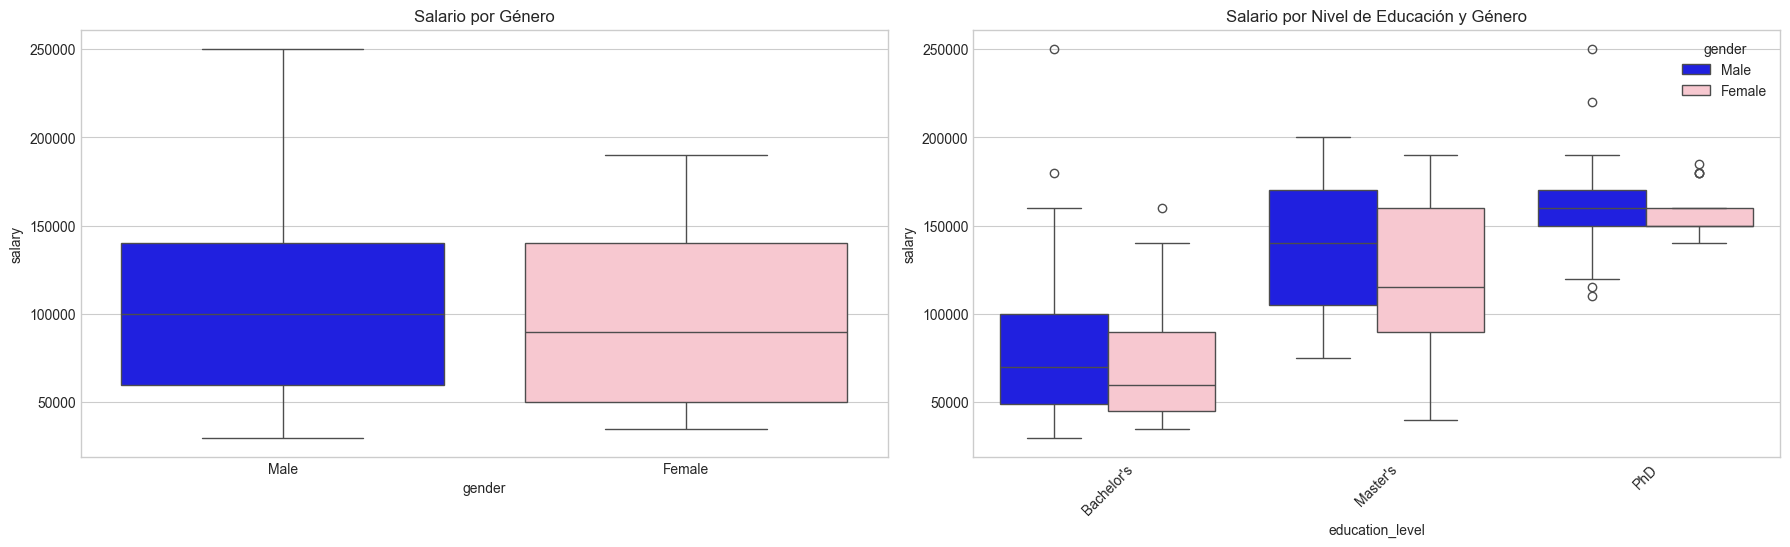

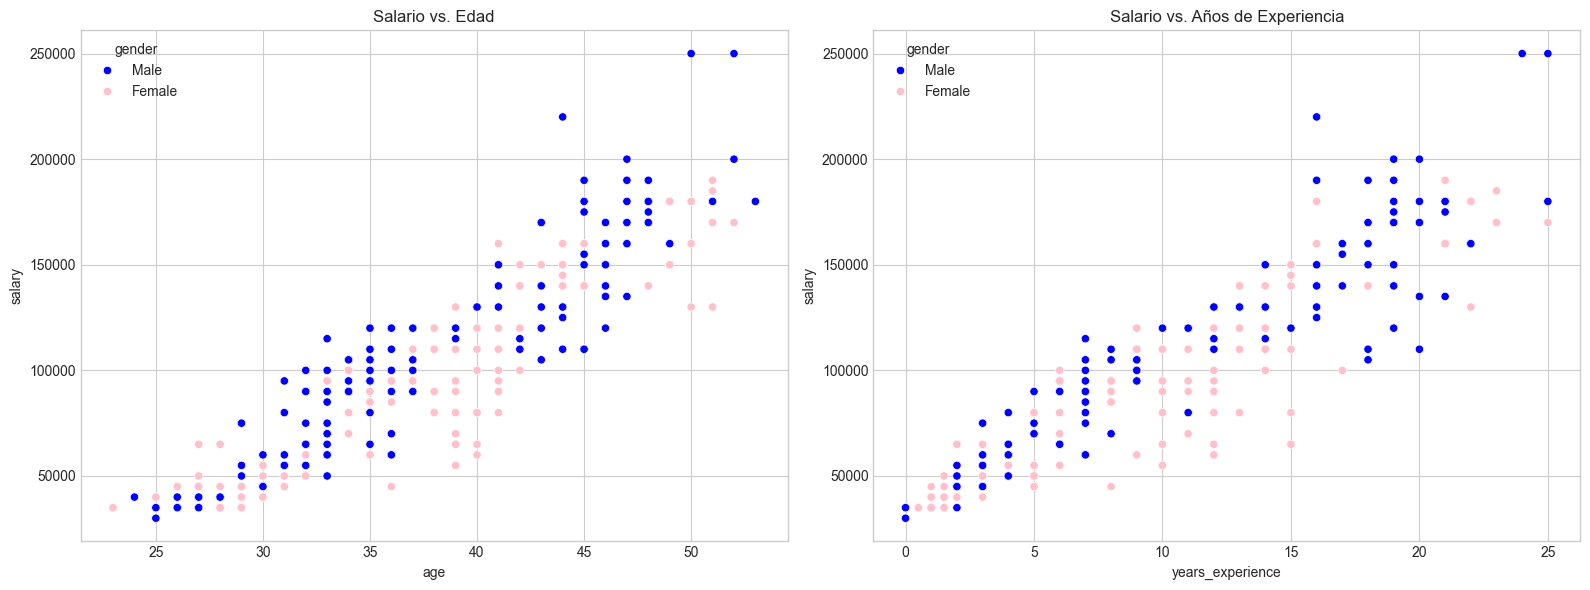

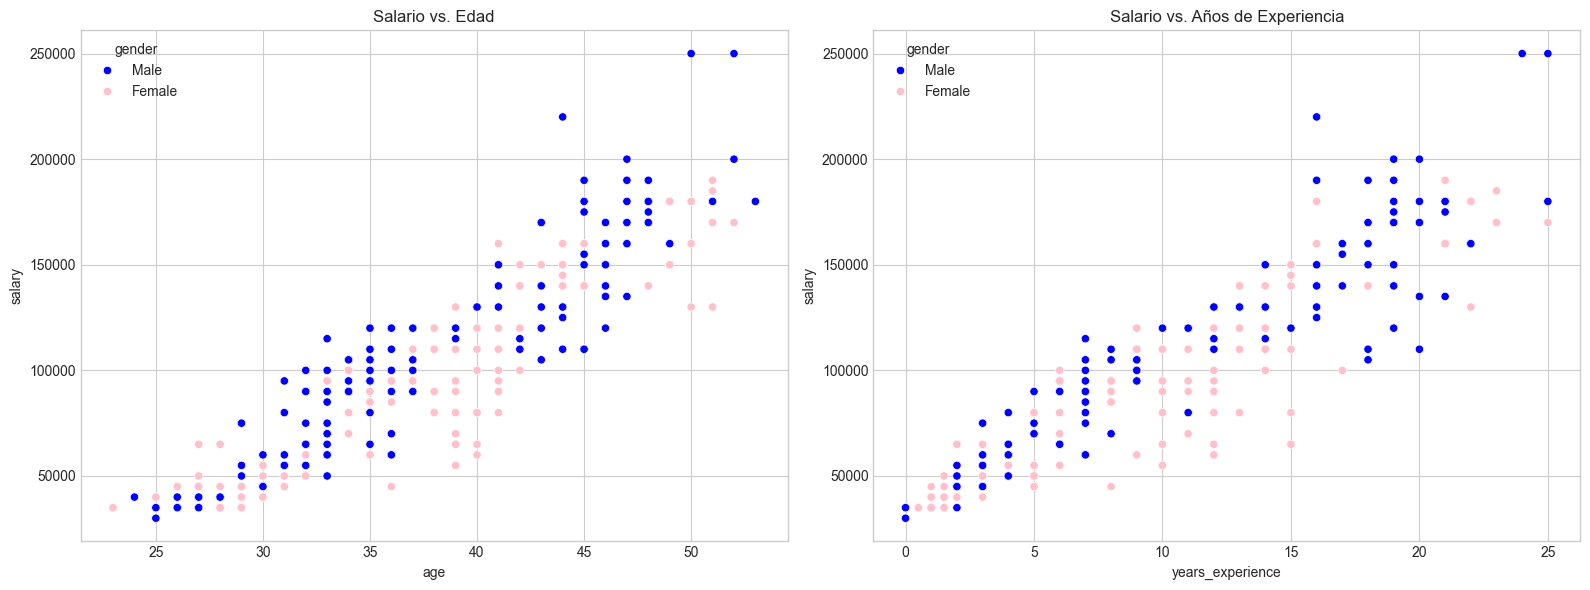

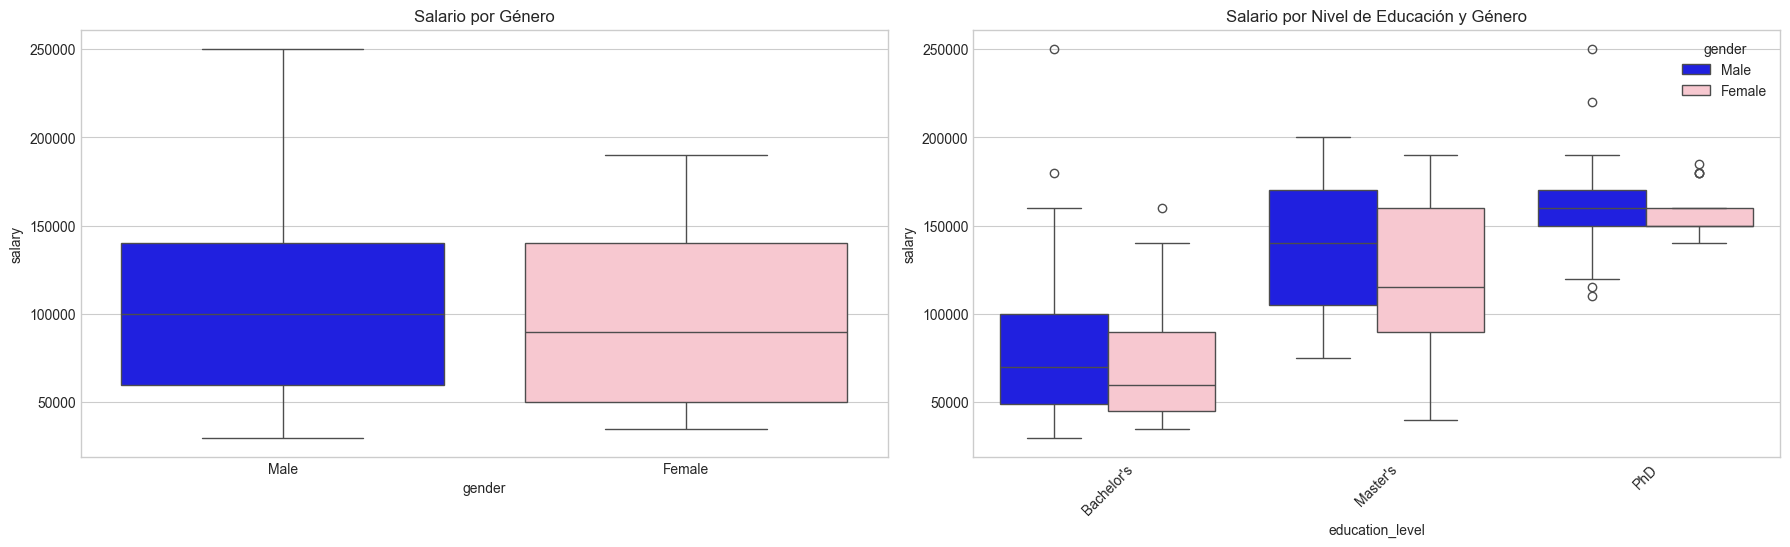

In [24]:
print("🎓 ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*45)

# Análisis de nivel educativo
education_stats = df_completo['education_level'].value_counts()
print(f"📚 Distribución por Nivel Educativo:")
for nivel, cantidad in education_stats.items():
    porcentaje = (cantidad / len(df_completo)) * 100
    print(f"   * {nivel:<12}: {cantidad:>3} registros ({porcentaje:>5.1f}%)")

# Análisis de género
print(f"\n👥 Distribución por Género:")
gender_stats = df_completo['gender'].value_counts(dropna=False)
for genero, cantidad in gender_stats.items():
    porcentaje = (cantidad / len(df_completo)) * 100
    genero_label = genero if pd.notna(genero) else "No especificado"
    print(f"   * {genero_label:<15}: {cantidad:>3} registros ({porcentaje:>5.1f}%)")
print(f"\n📝 Al visualizar los sueldos promedios para las variables genero y nievel se educación vs el salario")    
print(f"Vemos que los sueldos promedios, son mayores en los hombres, si no se consideran los años de experiencia y edad")

# Análisis de diversidad de puestos
job_stats = df_completo['job_title'].value_counts()
print(f"\n💼 Diversidad de Puestos de Trabajo:")
print(f"   * Total de títulos únicos: {len(job_stats)}")
print(f"   * Top 10 puestos más frecuentes:")
for i, (puesto, cantidad) in enumerate(job_stats.head(10).items(), 1):
    print(f"     {i:>2}. {puesto:<35}: {cantidad:>2} registros")

fragmentacion = sum(1 for count in job_stats if count == 1)
print(f"   * Puestos con un solo registro: {fragmentacion} ({(fragmentacion/len(job_stats)*100):.1f}%)")

print(f"\n\n 👥 Compatativa de  por Género y Nivel de educación 🎓")
print("="*135)

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='gender', y='salary', data=df_completo, palette={'Male': 'blue', 'Female': 'pink'})
plt.title('Salario por Género')

plt.subplot(2, 2, 2)
sns.boxplot(x='education_level', y='salary', hue='gender', data=df_completo, palette={'Male': 'blue', 'Female': 'pink'})
plt.title('Salario por Nivel de Educación y Género')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

### 6.4 Análisis de Correlaciones

Examinamos las relaciones entre variables numéricas para identificar patrones de dependencia que son cruciales para el diseño del modelo predictivo.

🔗 ANÁLISIS DE CORRELACIONES
📊 Matriz de correlaciones:


,age,years_experience,salary
age,1.0000,0.9794,0.9231
years_experience,0.9794,1.0000,0.9309
salary,0.9231,0.9309,1.0000



📈 Diagrama de dispersión:


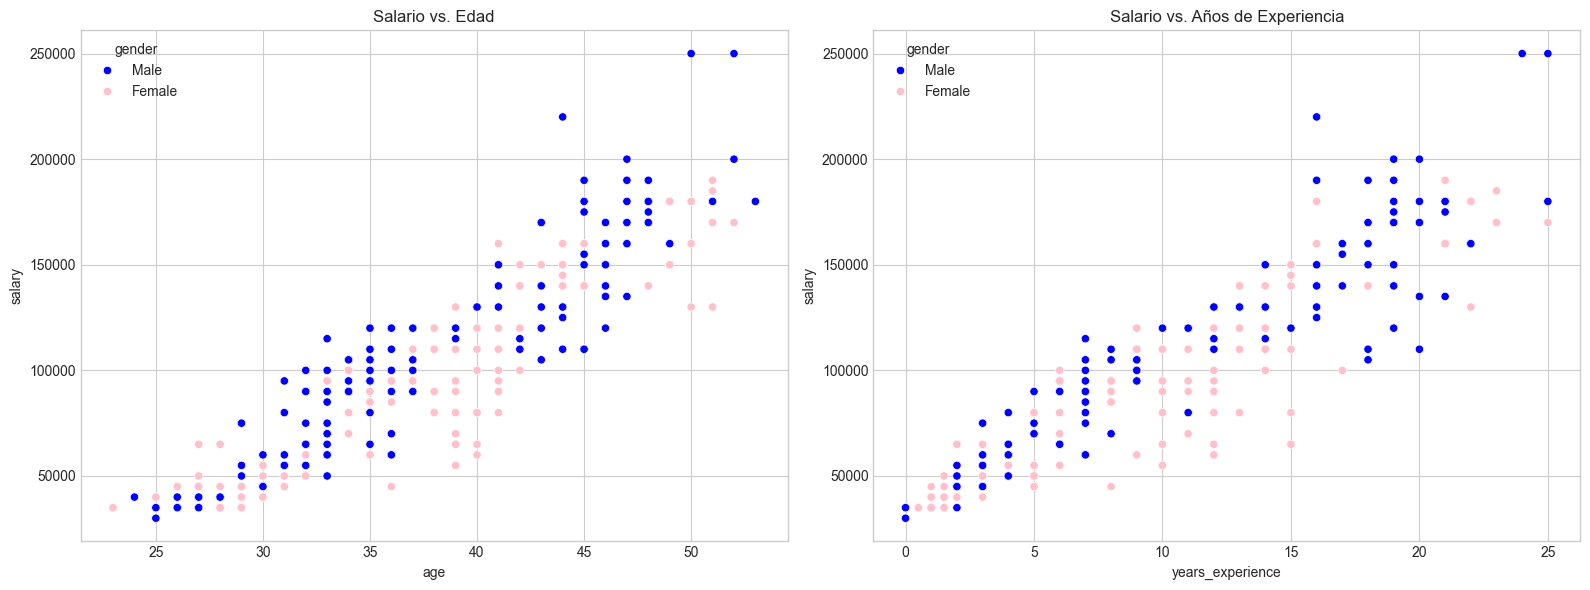


🔍 Interpretación de correlaciones:

   🎯 Correlaciones de mayor impacto:
      * Edad ↔ Experiencia: 0.979 (Muy Alta)
      * Experiencia ↔ Salario: 0.931 (Muy Alta)
      * Edad ↔ Salario: 0.923 (Muy Alta)

   ⚠️ Implicaciones para los modelos:
      * Edad y experiencia altamente correlacionadas
      * Se deberan considerar nuevas variables o regularización
      * La experiencia es altamente predictiva del salario
      * Los modelos lineales podrían funcionar bien


In [25]:
print("🔗 ANÁLISIS DE CORRELACIONES")
print("="*35)

# Matriz de correlaciones
variables_numericas = ['age', 'years_experience', 'salary']
correlation_matrix = df_completo[variables_numericas].corr()

print("📊 Matriz de correlaciones:")
display(correlation_matrix.round(4))

# Relación entre variables numéricas y salario
print("\n📈 Diagrama de dispersión:")
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='age', y='salary', hue='gender', data=df_completo, palette={'Male': 'blue', 'Female': 'pink'})
plt.title('Salario vs. Edad')


plt.subplot(1, 2, 2)
sns.scatterplot(x='years_experience', y='salary', hue='gender', data=df_completo, palette={'Male': 'blue', 'Female': 'pink'})
plt.title('Salario vs. Años de Experiencia')

plt.tight_layout()
plt.show()

# Interpretación de correlaciones
print("\n🔍 Interpretación de correlaciones:")

age_exp_corr = correlation_matrix.loc['age', 'years_experience']
exp_salary_corr = correlation_matrix.loc['years_experience', 'salary']
age_salary_corr = correlation_matrix.loc['age', 'salary']

print(f"\n   🎯 Correlaciones de mayor impacto:")
print(f"      * Edad ↔ Experiencia: {age_exp_corr:.3f} ({'Muy Alta' if age_exp_corr > 0.9 else 'Alta' if age_exp_corr > 0.7 else 'Moderada'})")
print(f"      * Experiencia ↔ Salario: {exp_salary_corr:.3f} ({'Muy Alta' if exp_salary_corr > 0.9 else 'Alta' if exp_salary_corr > 0.7 else 'Moderada'})")
print(f"      * Edad ↔ Salario: {age_salary_corr:.3f} ({'Muy Alta' if age_salary_corr > 0.9 else 'Alta' if age_salary_corr > 0.7 else 'Moderada'})")

print(f"\n   ⚠️ Implicaciones para los modelos:")
if age_exp_corr > 0.95:
    print(f"      * Edad y experiencia altamente correlacionadas")
    print(f"      * Se deberan considerar nuevas variables o regularización")
if exp_salary_corr > 0.9:
    print(f"      * La experiencia es altamente predictiva del salario")
    print(f"      * Los modelos lineales podrían funcionar bien")

    

## 7. Conclusiones y Insights

### 📊 Resumen Ejecutivo del Dataset

| Métrica | Valor |
|---------|-------|
| **Registros finales** | 373 empleados |
| **Variables predictoras** | 7 (age, gender, education_level, job_title, years_experience, description) |
| **Variable objetivo** | salary |
| **Completitud de datos** | >98% (solo 7 valores con nulos restantes) |
| **Diversidad de roles** | 174 títulos únicos |

### 🎯 Hallazgos Principales
#### 💰 **Distribución de Salarios**
- **Rango**: $30,000 - $250,000
- **Media**: $100,670 | **Mediana**: $95,000
- **Desviación estándar**: $48,079 (alta variabilidad)
#### 👥 **Perfil Demográfico**
- **Edad promedio**: 37.4 años (rango: 23-53 años)
- **Experiencia promedio**: 10 años (rango: 0-25 años)
- **Educación**: 60% Bachelor's, 26% Master's, 14% PhD
- **Género**: Distribución relativamente equilibrada
#### 🔗 **Patrones de Correlación**
- **Edad ↔ Experiencia**: 0.979 (casi perfecta)
- **Experiencia ↔ Salario**: 0.931 (muy fuerte)
- **Edad ↔ Salario**: 0.923 (muy fuerte)
#### 💼 **Diversidad Profesional**
- **174 títulos únicos** indican alta especialización y dispersión, se podrían estandarizar
- **Alta fragmentación**: 40% de puestos tienen un solo representante
- **Jerarquías Amplias**: Desde roles junior hasta directivos
### 🚨 **Desafíos Identificados**
#### 1. **Multicolinealidad Alta**
- Correlación edad-experiencia de 0.979 puede causar problemas en modelos lineales
- **Recomendación**: Considerar PCA o selección de features en modelos avanzados.
#### 2. **Complejidad Categórica**
- 174 job_titles únicos requieren técnicas de encoding sofisticadas
- **Recomendación**: Agrupar roles similares o usar embeddings
#### 3. **Valores Faltantes Estratégicos**
- 3 registros sin género (0.8%)
- 1 registro sin edad (0.3%)
- **Recomendación**: Modelos robustos a missing values
### 🎯 **Consideraciónes para Modelado**

1. **Feature Engineering**:
   - Crear categorías de experiencia (Junior/Mid/Senior)
   - Agrupar job_titles por familia de roles
   - Se intentará Extraer información adicional de descripciones
2. **Tratamiento de Multicolinealidad**:
   - Usar solo years_experience (No tiene tanta correlación como age y no presenta valores nulos)
   - Aplicar regularización (Ridge/Lasso)
3. **Encoding de Variables Categóricas**:
   - Se utilizará ollama para intentar estandarizar los campos job_title.
   - Se utilizará One-hot encoding para education_level y gender
#### **Modelos a Desarrollar**
1. **Baseline**: Regresión Lineal con regularización
2. **Avanzados**: Random Forest, LGBM (manejo nativo de categorías)
#### **Métricas de Evaluación**
- **Primaria**: RMSE (por naturaleza continua del target)
- **Secundaria**: MAE, R² score
- **Validación**: K-fold cross-validation (k=5)


In [26]:
# Resumen luego del EDA
print("🎊 RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("="*55)
print(f"📊 Dataset final: {df_completo.shape[0]} registros × {df_completo.shape[1]} variables")
print(f"✅ Completitud: {((df_completo.count().sum() / (df_completo.shape[0] * df_completo.shape[1])) * 100):.1f}%")
print(f"🎯 Variable objetivo: salary (${df_completo['salary'].min():,.0f} - ${df_completo['salary'].max():,.0f})")
print(f"🔗 Correlación más fuerte: years_experience ↔ salary ({df_completo[['years_experience', 'salary']].corr().iloc[0,1]:.3f})")
print("\n✨ Dataset listo para la fase de modelado")

🎊 RESUMEN DEL ANÁLISIS EXPLORATORIO
📊 Dataset final: 373 registros × 8 variables
✅ Completitud: 99.8%
🎯 Variable objetivo: salary ($30,000 - $250,000)
🔗 Correlación más fuerte: years_experience ↔ salary (0.931)

✨ Dataset listo para la fase de modelado


## 8. Feature engineering

En base a variables númericas se generan las siguientes variables

In [27]:
# Variables generadas en base a las exsitentes.
#df_completo = fu.ejecutar_query("SELECT * FROM df_completo")

# Resto a la edad los años de experiencia.
df_completo["inicio_laboral"] = df_completo["age"] - df_completo["years_experience"]
df_completo["ratio_experiencia"] =  df_completo["years_experience"] / df_completo["age"]
# Velocidad de carrera, intenta reflejar 
df_completo["ratio_velocidad_carrera"] = df_completo["years_experience"] / (df_completo["age"] - 22)
df_completo["experience2"] = df_completo["years_experience"] ** 2
df_completo["experience3"] = df_completo["years_experience"] ** 3
# edad x experiencia
df_completo["edad_x_experiencia"] = df_completo["age"] * df_completo["years_experience"]
# edad x experiencia al cuadrado
df_completo["edad_x_experiencia2"] = df_completo["age"] * df_completo["experience2"]
#Log experiencia (log_experiencia = log(1 + años_experiencia))
df_completo["log_experiencia"] = df_completo["years_experience"].apply(lambda x: 0 if x == 0 else np.log(1 + x))
educacion_numerica = {"Bachelor's": 1, "Master's": 2, "PhD": 3}
df_completo["education_numerica"] = df_completo["education_level"].map(educacion_numerica)
df_completo["educacion_x_experiencia"] = df_completo["education_numerica"] * df_completo["years_experience"]


En base a variables categóricas


In [28]:
# gender y education_level
df_completo['gender_education'] = df_completo['gender'] + "_" + df_completo['education_level']

Utilizando ollama

Se intenta obtener desde el Job Title, el nivel de seniority, el area y una expectativa del salario.

In [17]:
# intento obtener usando ollama, con el job_title, el nivel de seniority, el area y una expetativa de salario, alto/medio/bajo. con un intervalo de confianza.
ollama_job_title = ollama.run_classification(df_completo,'job_title','job_title')

# Analizar descripciones
#df_completo = df_completo.head(10)
#df_analyzed = run_description_analysis(
#    df_completo, 
#    description_column='description',
#    table_name='df_descriptions_analyzed_3',
#    model_name="llama3:8b"
#)

=== CLASIFICACIÓN CON OLLAMA - Modelo: llama3:8b ===
Ollama conectado. Modelos disponibles: ['llama3:8b']
✅ Usando modelo: llama3:8b
Clasificando 174 títulos únicos con llama3:8b...
Procesando lote 1/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 2/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 3/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 4/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 5/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 6/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 7/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 8/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 9/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 10/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 11/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 12/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 13/35: 5 títulos
  ✅ Clasificados 5 títulos
Procesando lote 14/35: 5 títulos
  ✅ Clasificad

#### En las graficas de las variables categóricas generadas en ollama, observamos:

**Nivel de seniority:** logra identificar bastante bien los niveles en base al salario.

**Expectativa del salario:** No logra separar de manera clara, las medias de las distintas categorías no se identifican a simple vista.



 📊 Análisis de salarios en base a variables del LLM 📈 


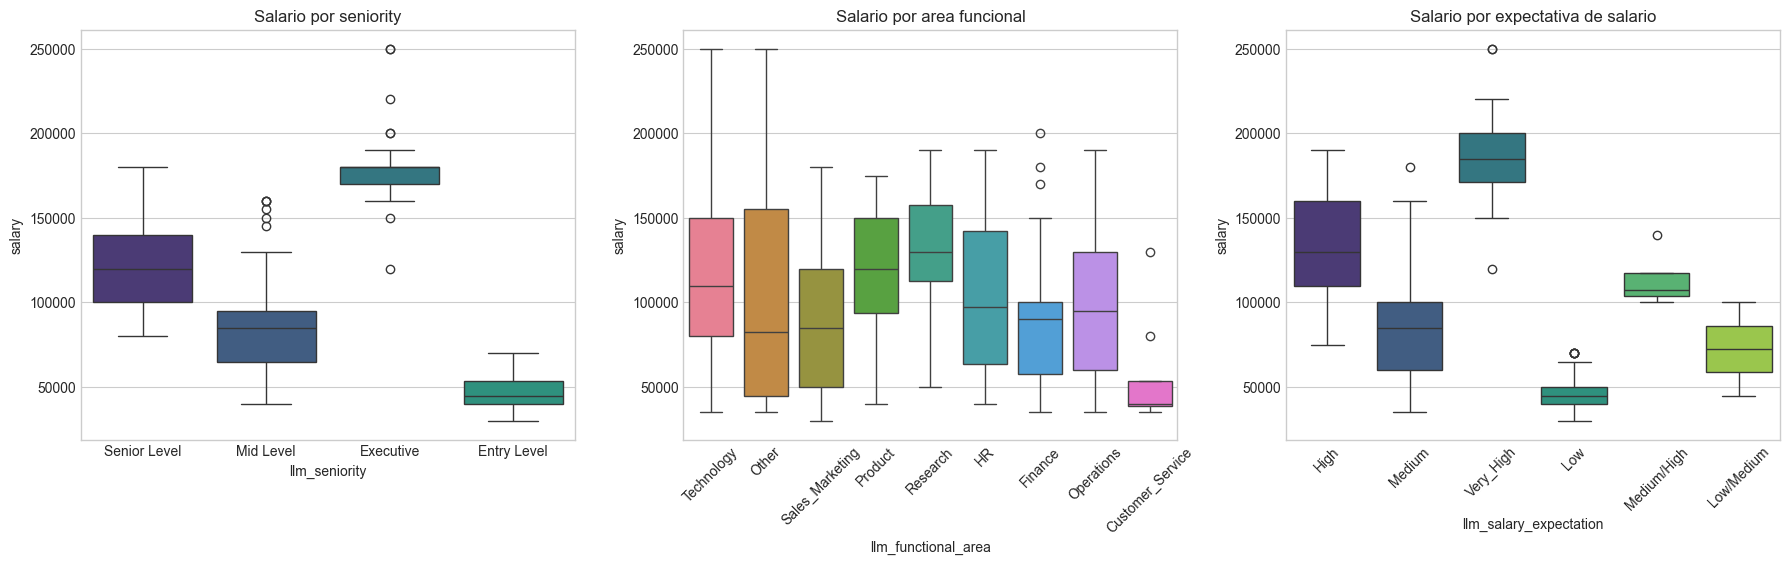

In [29]:
# Obtengo el df completo nuevamente, ahora tiene lo generado en ollama
df_completo = fu.ejecutar_query("SELECT * FROM job_title")

print(f"\n\n 📊 Análisis de salarios en base a variables del LLM 📈 ")
print("="*135)

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
sns.boxplot(x='llm_seniority', y='salary', hue='llm_seniority', data=df_completo)
plt.title('Salario por seniority')

plt.subplot(2, 3, 2)
sns.boxplot(x='llm_functional_area', y='salary', hue='llm_functional_area', data=df_completo)
plt.title('Salario por area funcional')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
sns.boxplot(x='llm_salary_expectation', y='salary', hue='llm_salary_expectation', data=df_completo)
plt.title('Salario por expectativa de salario')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [30]:
# guardo el ds con FE
fu.cargar_df_a_db(df_completo, 'df_feature_engineering')
df = df_completo.copy()
del df_completo


Tabla 'df_feature_engineering' creada o reemplazada en DuckDB.


# 9. Regresión Lineal

Comenzamos con una regresión lineal simple usando solo la variable más correlacionada con el salario: años de experiencia.

In [31]:
# Lista para almacenar resultados
resultados_modelos = []

# Preparar datos para regresión simple
X_simple = df[['years_experience']].copy()
y = df['salary'].copy()

# Verificar correlación
correlacion = df[['years_experience', 'salary']].corr().iloc[0, 1]
print(f"Correlación years_experience vs salary: {correlacion:.4f}")

# División train/test
X_train_simple, X_test_simple, y_train, y_test = train_test_split(
    X_simple, y, test_size=0.2, random_state=42
)

# Modelo de regresión lineal simple
modelo_simple = LinearRegression()
modelo_simple.fit(X_train_simple, y_train)

# Predicciones
y_pred_simple_train = modelo_simple.predict(X_train_simple)
y_pred_simple_test = modelo_simple.predict(X_test_simple)

# Evaluación
print("=== REGRESIÓN LINEAL SIMPLE ===")
print("\nEntrenamiento:")
resultados_simple_train = bl.evaluar_modelo_con_ic(y_train, y_pred_simple_train, "Lineal Simple (Train)")

print("\nPrueba:")
resultados_simple_test = bl.evaluar_modelo_con_ic(y_test, y_pred_simple_test, "Lineal Simple (Test)")
resultados_modelos.append(resultados_simple_test)

# Validación cruzada con intervalos de confianza
print("\n=== VALIDACIÓN CRUZADA - REGRESIÓN SIMPLE ===")
cv_results_simple = bl.cross_validation_con_ic(
    LinearRegression(), X_train_simple, y_train, cv=3
)

## Coeficientes del modelo con intervalos de confianza
print(f"\nCoeficientes del modelo:")
print(f"  Intercepto: ${modelo_simple.intercept_:,.2f}")
print(f"  Pendiente: ${modelo_simple.coef_[0]:,.2f} por año de experiencia")
ic_coeficientes_simple = bl.calcular_ic_coeficientes(modelo_simple, X_train_simple, y_train)


Correlación years_experience vs salary: 0.9309
=== REGRESIÓN LINEAL SIMPLE ===

Entrenamiento:

Lineal Simple (Train):
  RMSE: $18,017.82 (95% IC: $15,826.19 - $20,093.80)
  MAE:  $12,685.70 (95% IC: $11,294.13 - $14,063.58)
  R²:   0.8577 (95% IC: 0.8172 - 0.8884)

Prueba:

Lineal Simple (Test):
  RMSE: $15,536.20 (95% IC: $12,507.67 - $18,508.25)
  MAE:  $12,103.64 (95% IC: $9,970.84 - $14,296.77)
  R²:   0.8993 (95% IC: 0.8541 - 0.9325)

=== VALIDACIÓN CRUZADA - REGRESIÓN SIMPLE ===
R2:
  Media: 0.8533 ± 0.0167
  95% IC: 0.8118 - 0.8948
  Scores individuales: [0.85234418 0.87425108 0.83336605]

Root Mean Squared Error:
  Media: 18088.8066 ± 1534.0511
  95% IC: 14278.0124 - 21899.6008
  Scores individuales: [16763.21175016 17264.30177001 20238.90625207]

Mean Absolute Error:
  Media: 12834.4613 ± 980.6923
  95% IC: 10398.2866 - 15270.6361
  Scores individuales: [11705.40155544 12701.45694685 14096.52552246]


Coeficientes del modelo:
  Intercepto: $31,873.51
  Pendiente: $6,799.10 po

=== GRÁFICO CON INTERVALOS DE CONFIANZA CORREGIDO ===


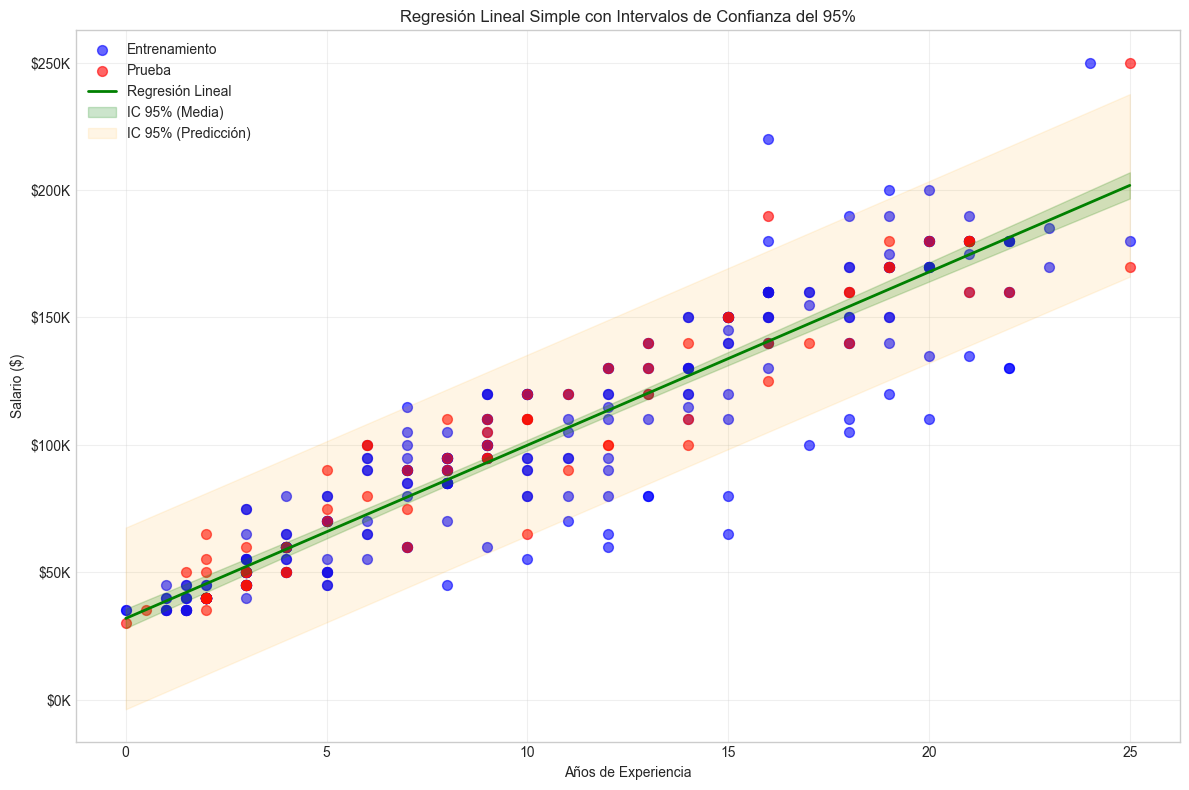

    ESTADÍSTICAS DE INTERVALOS DE CONFIANZA
Ancho promedio IC confianza: $6,117
Ancho promedio IC predicción: $71,203
Ratio IC predicción / IC confianza: 11.6x

Estadísticas del modelo:
RMSE: $15,536
Media residuos: $2,965
Std residuos: $15,251


In [32]:
#Opción 1: Función corregida completa
print("=== GRÁFICO CON INTERVALOS DE CONFIANZA CORREGIDO ===")
bl.plot_regresion_simple_con_ic_corregida(modelo_simple, X_train_simple, y_train, X_test_simple, y_test, X_simple)

# Opción 2: verion básica
#print("\n=== VERSIÓN BÁSICA (SI HAY PROBLEMAS) ===")
#bl.plot_regresion_simple_basico(modelo_simple, X_train_simple, y_train, X_test_simple, y_test, X_simple)

## 9.1 Regresión Lineal Múltiple

Se agregan variables al análisis para dar mas capacidad de predicción a la regresión

In [34]:
# Seleccionar variables para regresión múltiple
# Variables numéricas básicas
#variables_numericas = ['age', 'years_experience']
variables_numericas = [ 'years_experience']

# Agregar variables de feature engineering si existen
variables_engineered = ['ratio_experiencia', 'log_experiencia', 'education_numerica']
#variables_engineered = ['ratio_experiencia', 'log_experiencia', 'educacion_x_experiencia']
for var in variables_engineered:
    if var in df.columns:
        variables_numericas.append(var)

# Variables categóricas
#variables_categoricas = ['gender', 'education_level']
variables_categoricas = ['llm_functional_area', 'llm_seniority']

print(f"Variables numéricas seleccionadas: {variables_numericas}")
print(f"Variables categóricas seleccionadas: {variables_categoricas}")

# Verificar disponibilidad de variables
variables_disponibles = [var for var in variables_numericas if var in df.columns]
categoricas_disponibles = [var for var in variables_categoricas if var in df.columns]

print(f"\nVariables disponibles en el dataset:")
print(f"  Numéricas: {variables_disponibles}")
print(f"  Categóricas: {categoricas_disponibles}")

# Preparar datos para regresión múltiple
# Crear dataset sin valores faltantes
df_clean = df.dropna(subset=variables_disponibles + categoricas_disponibles + ['salary'])

print(f"Registros después de eliminar valores faltantes: {len(df_clean)}")

# Preparar matriz de características
X_num = df_clean[variables_disponibles].copy()

# Encoding de variables categóricas
X_multiple = X_num.copy()

for var in categoricas_disponibles:
    if var in df_clean.columns:
        # One-hot encoding para variables categóricas
        dummies = pd.get_dummies(df_clean[var], prefix=var, drop_first=True)
        X_multiple = pd.concat([X_multiple, dummies], axis=1)

y_multiple = df_clean['salary'].copy()

print(f"\nForma final de X: {X_multiple.shape}")
print(f"Columnas finales: {list(X_multiple.columns)}")

Variables numéricas seleccionadas: ['years_experience', 'ratio_experiencia', 'log_experiencia', 'education_numerica']
Variables categóricas seleccionadas: ['llm_functional_area', 'llm_seniority']

Variables disponibles en el dataset:
  Numéricas: ['years_experience', 'ratio_experiencia', 'log_experiencia', 'education_numerica']
  Categóricas: ['llm_functional_area', 'llm_seniority']
Registros después de eliminar valores faltantes: 372

Forma final de X: (372, 15)
Columnas finales: ['years_experience', 'ratio_experiencia', 'log_experiencia', 'education_numerica', 'llm_functional_area_Finance', 'llm_functional_area_HR', 'llm_functional_area_Operations', 'llm_functional_area_Other', 'llm_functional_area_Product', 'llm_functional_area_Research', 'llm_functional_area_Sales_Marketing', 'llm_functional_area_Technology', 'llm_seniority_Executive', 'llm_seniority_Mid Level', 'llm_seniority_Senior Level']


In [35]:
# División train/test para modelo múltiple
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(
    X_multiple, y_multiple, test_size=0.2, random_state=42
)

# Escalado de variables (importante para regularización posterior)
scaler = StandardScaler()
X_train_mult_scaled = scaler.fit_transform(X_train_mult)
X_test_mult_scaled = scaler.transform(X_test_mult)

# Modelo de regresión múltiple
modelo_multiple = LinearRegression()
modelo_multiple.fit(X_train_mult, y_train_mult)

# Predicciones
y_pred_mult_train = modelo_multiple.predict(X_train_mult)
y_pred_mult_test = modelo_multiple.predict(X_test_mult)

# Evaluación CON INTERVALOS DE CONFIANZA
print("=== REGRESIÓN LINEAL MÚLTIPLE ===")
print("\nEntrenamiento:")
resultados_mult_train = bl.evaluar_modelo_con_ic(y_train_mult, y_pred_mult_train, "Lineal Múltiple (Train)")

print("\nPrueba:")
resultados_mult_test = bl.evaluar_modelo_con_ic(y_test_mult, y_pred_mult_test, "Lineal Múltiple (Test)")
resultados_modelos.append(resultados_mult_test)

# Validación cruzada con intervalos de confianza
print("\n=== VALIDACIÓN CRUZADA - REGRESIÓN MÚLTIPLE ===")
cv_results_multiple = bl.cross_validation_con_ic(
    LinearRegression(), X_train_mult, y_train_mult, cv=5
)

=== REGRESIÓN LINEAL MÚLTIPLE ===

Entrenamiento:

Lineal Múltiple (Train):
  RMSE: $11,395.45 (95% IC: $10,314.08 - $12,552.88)
  MAE:  $8,531.84 (95% IC: $7,760.93 - $9,396.99)
  R²:   0.9428 (95% IC: 0.9300 - 0.9535)

Prueba:

Lineal Múltiple (Test):
  RMSE: $12,648.63 (95% IC: $7,893.45 - $18,073.74)
  MAE:  $7,918.09 (95% IC: $5,815.92 - $10,442.18)
  R²:   0.9351 (95% IC: 0.8863 - 0.9714)

=== VALIDACIÓN CRUZADA - REGRESIÓN MÚLTIPLE ===
R2:
  Media: 0.9339 ± 0.0139
  95% IC: 0.9166 - 0.9511
  Scores individuales: [0.91101854 0.95299497 0.94178467 0.93028621 0.93333537]

Root Mean Squared Error:
  Media: 12010.3751 ± 1610.9010
  95% IC: 10010.1774 - 14010.5729
  Scores individuales: [12935.2854396   9347.2071653  11608.03543991 14215.16292788
 11946.18474352]

Mean Absolute Error:
  Media: 9016.3944 ± 1161.4870
  95% IC: 7574.2179 - 10458.5710
  Scores individuales: [10133.57512375  7137.06137013  8342.71223119 10224.52398101
  9244.09941092]




=== Gráficos RL Multiple ===


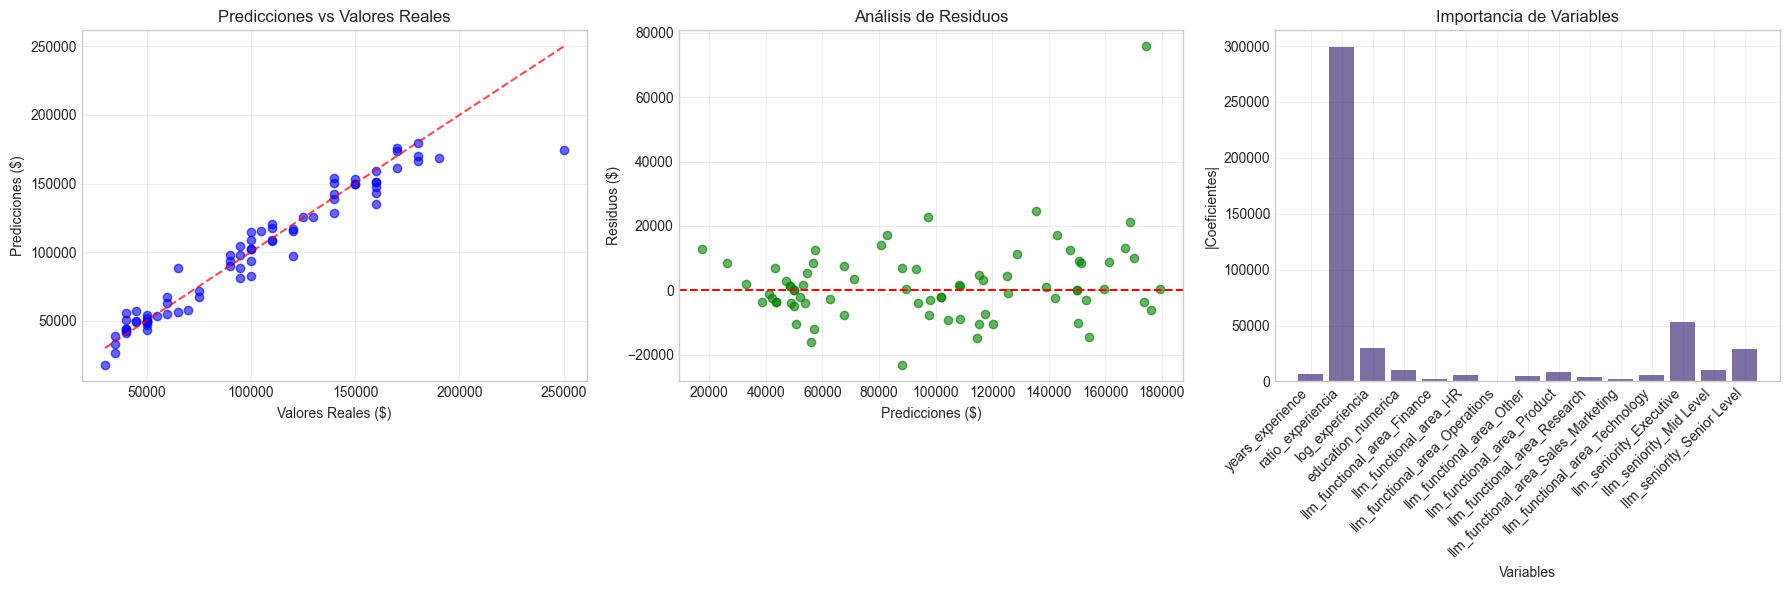

In [36]:
#resultados_multiple = bl.plot_regresion_multiple_completa(modelo_multiple, X_train_mult, y_train_mult, X_test_mult, y_test_mult, X_multiple.columns.tolist())

print("\n=== Gráficos RL Multiple ===")
bl.plot_regresion_multiple_simple(
    modelo_multiple, 
    X_train_mult, 
    y_train_mult, 
    X_test_mult, 
    y_test_mult, 
    X_multiple.columns.tolist()
)

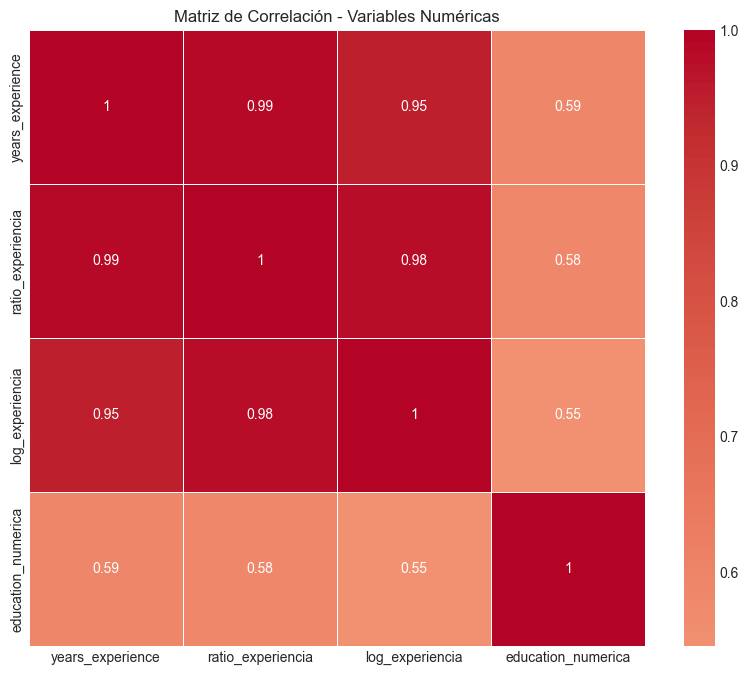


Correlaciones altas (>0.8) entre variables predictoras:
  years_experience - ratio_experiencia: 0.987
  years_experience - log_experiencia: 0.948
  ratio_experiencia - log_experiencia: 0.979


In [37]:
if len(variables_disponibles) > 1:
    correlacion_matrix = X_multiple[variables_disponibles].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlacion_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Matriz de Correlación - Variables Numéricas')
    plt.show()
    
    # Identificar correlaciones altas
    print("\nCorrelaciones altas (>0.8) entre variables predictoras:")
    for i in range(len(correlacion_matrix.columns)):
        for j in range(i+1, len(correlacion_matrix.columns)):
            if abs(correlacion_matrix.iloc[i, j]) > 0.8:
                print(f"  {correlacion_matrix.columns[i]} - {correlacion_matrix.columns[j]}: {correlacion_matrix.iloc[i, j]:.3f}")

## 9.2 Regresión con Regularización

Aplicamos regularización al mejor modelo anterior para solucionar problemas multicolinealidad


In [38]:
# Determinar el mejor modelo base para aplicar regularización
if len(resultados_modelos) >= 2:
    mejor_r2 = max(resultados_modelos, key=lambda x: x['R²'])
    print(f"Mejor modelo base: {mejor_r2['Modelo']} (R² = {mejor_r2['R²']:.4f})")
    
    # Usar el modelo múltiple como base para regularización
    X_reg = X_train_mult_scaled
    X_test_reg = X_test_mult_scaled
    y_reg = y_train_mult
    y_test_reg = y_test_mult
    feature_names = X_multiple.columns
else:
    # Fallback al modelo simple
    scaler_simple = StandardScaler()
    X_reg = scaler_simple.fit_transform(X_train_simple)
    X_test_reg = scaler_simple.transform(X_test_simple)
    y_reg = y_train
    y_test_reg = y_test
    feature_names = X_simple.columns

print(f"\nForma de datos para regularización: {X_reg.shape}")

Mejor modelo base: Lineal Múltiple (Test) (R² = 0.9351)

Forma de datos para regularización: (297, 15)


In [39]:
# Validación cruzada para encontrar mejor alpha
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Ridge Regression
ridge_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_reg, y_reg, cv=cv, scoring='r2')
    ridge_scores.append(scores.mean())

# Lasso Regression
lasso_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=2000)
    scores = cross_val_score(lasso, X_reg, y_reg, cv=cv, scoring='r2')
    lasso_scores.append(scores.mean())

# Encontrar mejores alphas
mejor_alpha_ridge = alphas[np.argmax(ridge_scores)]
mejor_alpha_lasso = alphas[np.argmax(lasso_scores)]

print(f"Mejor alpha para Ridge: {mejor_alpha_ridge} (R² = {max(ridge_scores):.4f})")
print(f"Mejor alpha para Lasso: {mejor_alpha_lasso} (R² = {max(lasso_scores):.4f})")

Mejor alpha para Ridge: 0.01 (R² = 0.9354)
Mejor alpha para Lasso: 1 (R² = 0.9354)


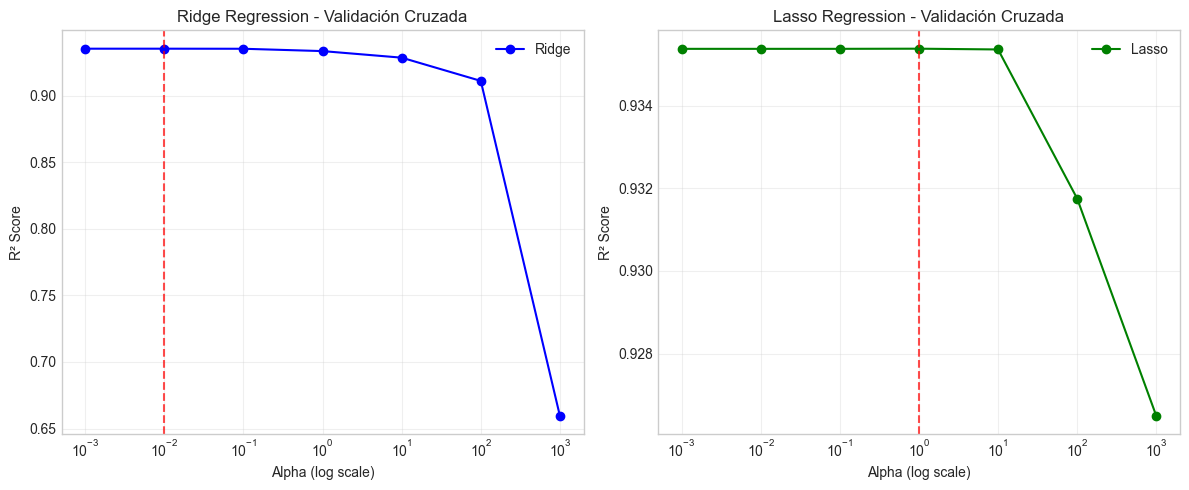

In [40]:
# Visualización de la validación cruzada
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogx(alphas, ridge_scores, 'b-o', label='Ridge')
plt.axvline(x=mejor_alpha_ridge, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Alpha (log scale)')
plt.ylabel('R² Score')
plt.title('Ridge Regression - Validación Cruzada')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogx(alphas, lasso_scores, 'g-o', label='Lasso')
plt.axvline(x=mejor_alpha_lasso, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Alpha (log scale)')
plt.ylabel('R² Score')
plt.title('Lasso Regression - Validación Cruzada')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Entrenar modelos con regularización
# Ridge
modelo_ridge = Ridge(alpha=mejor_alpha_ridge)
modelo_ridge.fit(X_reg, y_reg)
y_pred_ridge = modelo_ridge.predict(X_test_reg)

# Lasso
modelo_lasso = Lasso(alpha=mejor_alpha_lasso, max_iter=2000)
modelo_lasso.fit(X_reg, y_reg)
y_pred_lasso = modelo_lasso.predict(X_test_reg)

# Elastic Net
modelo_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000)
modelo_elastic.fit(X_reg, y_reg)
y_pred_elastic = modelo_elastic.predict(X_test_reg)

print("=== MODELOS CON REGULARIZACIÓN ===")
resultados_ridge = bl.evaluar_modelo_con_ic(y_test_reg, y_pred_ridge, "Ridge Regression")
resultados_lasso = bl.evaluar_modelo_con_ic(y_test_reg, y_pred_lasso, "Lasso Regression")
resultados_elastic = bl.evaluar_modelo_con_ic(y_test_reg, y_pred_elastic, "Elastic Net")

resultados_modelos.extend([resultados_ridge, resultados_lasso, resultados_elastic])

# Validación cruzada para modelos regularizados
print("\n=== VALIDACIÓN CRUZADA - MODELOS REGULARIZADOS ===")

print("Ridge Regression:")
cv_results_ridge = bl.cross_validation_con_ic(
    Ridge(alpha=mejor_alpha_ridge), X_reg, y_reg, cv=5
)

print("Lasso Regression:")
cv_results_lasso = bl.cross_validation_con_ic(
    Lasso(alpha=mejor_alpha_lasso, max_iter=2000), X_reg, y_reg, cv=5
)

print("Elastic Net:")
cv_results_elastic = bl.cross_validation_con_ic(
    ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000), X_reg, y_reg, cv=5
)

=== MODELOS CON REGULARIZACIÓN ===

Ridge Regression:
  RMSE: $12,646.48 (95% IC: $7,921.63 - $17,919.91)
  MAE:  $7,916.23 (95% IC: $5,925.39 - $10,318.08)
  R²:   0.9351 (95% IC: 0.8893 - 0.9713)

Lasso Regression:
  RMSE: $12,646.93 (95% IC: $8,066.45 - $18,385.78)
  MAE:  $7,917.93 (95% IC: $5,970.45 - $10,539.67)
  R²:   0.9351 (95% IC: 0.8842 - 0.9710)

Elastic Net:
  RMSE: $13,200.66 (95% IC: $8,405.04 - $18,489.05)
  MAE:  $8,360.43 (95% IC: $6,335.85 - $10,846.41)
  R²:   0.9293 (95% IC: 0.8814 - 0.9687)

=== VALIDACIÓN CRUZADA - MODELOS REGULARIZADOS ===
Ridge Regression:
R2:
  Media: 0.9339 ± 0.0139
  95% IC: 0.9167 - 0.9511
  Scores individuales: [0.9109654  0.9529773  0.94171292 0.93031475 0.93354554]

Root Mean Squared Error:
  Media: 12008.5780 ± 1609.7857
  95% IC: 10009.7651 - 14007.3909
  Scores individuales: [12939.14740366  9348.96351904 11615.18670223 14212.25321532
 11927.338999  ]

Mean Absolute Error:
  Media: 9014.7914 ± 1161.6120
  95% IC: 7572.4596 - 10457.12

## 9.3 Comparación de Modelos

Comparamos todos los modelos implementados para identificar el de mejor performance

In [42]:
df_resultados = pd.DataFrame(resultados_modelos)
df_resultados = df_resultados.sort_values('R²', ascending=False)

print("=== COMPARACIÓN FINAL DE MODELOS CON INTERVALOS DE CONFIANZA ===")
print("\nResultados ordenados por R² (mayor a menor):")

# Mostrar tabla con formato mejorado
for _, row in df_resultados.iterrows():
    print(f"\n{row['Modelo']}:")
    print(f"  R²:   {row['R²']:.4f} (IC: {row['R²_CI_Lower']:.4f} - {row['R²_CI_Upper']:.4f})")
    print(f"  RMSE: ${row['RMSE']:,.0f} (IC: ${row['RMSE_CI_Lower']:,.0f} - ${row['RMSE_CI_Upper']:,.0f})")
    print(f"  MAE:  ${row['MAE']:,.0f} (IC: ${row['MAE_CI_Lower']:,.0f} - ${row['MAE_CI_Upper']:,.0f})")


=== COMPARACIÓN FINAL DE MODELOS CON INTERVALOS DE CONFIANZA ===

Resultados ordenados por R² (mayor a menor):

Ridge Regression:
  R²:   0.9351 (IC: 0.8893 - 0.9713)
  RMSE: $12,646 (IC: $7,922 - $17,920)
  MAE:  $7,916 (IC: $5,925 - $10,318)

Lasso Regression:
  R²:   0.9351 (IC: 0.8842 - 0.9710)
  RMSE: $12,647 (IC: $8,066 - $18,386)
  MAE:  $7,918 (IC: $5,970 - $10,540)

Lineal Múltiple (Test):
  R²:   0.9351 (IC: 0.8863 - 0.9714)
  RMSE: $12,649 (IC: $7,893 - $18,074)
  MAE:  $7,918 (IC: $5,816 - $10,442)

Elastic Net:
  R²:   0.9293 (IC: 0.8814 - 0.9687)
  RMSE: $13,201 (IC: $8,405 - $18,489)
  MAE:  $8,360 (IC: $6,336 - $10,846)

Lineal Simple (Test):
  R²:   0.8993 (IC: 0.8541 - 0.9325)
  RMSE: $15,536 (IC: $12,508 - $18,508)
  MAE:  $12,104 (IC: $9,971 - $14,297)


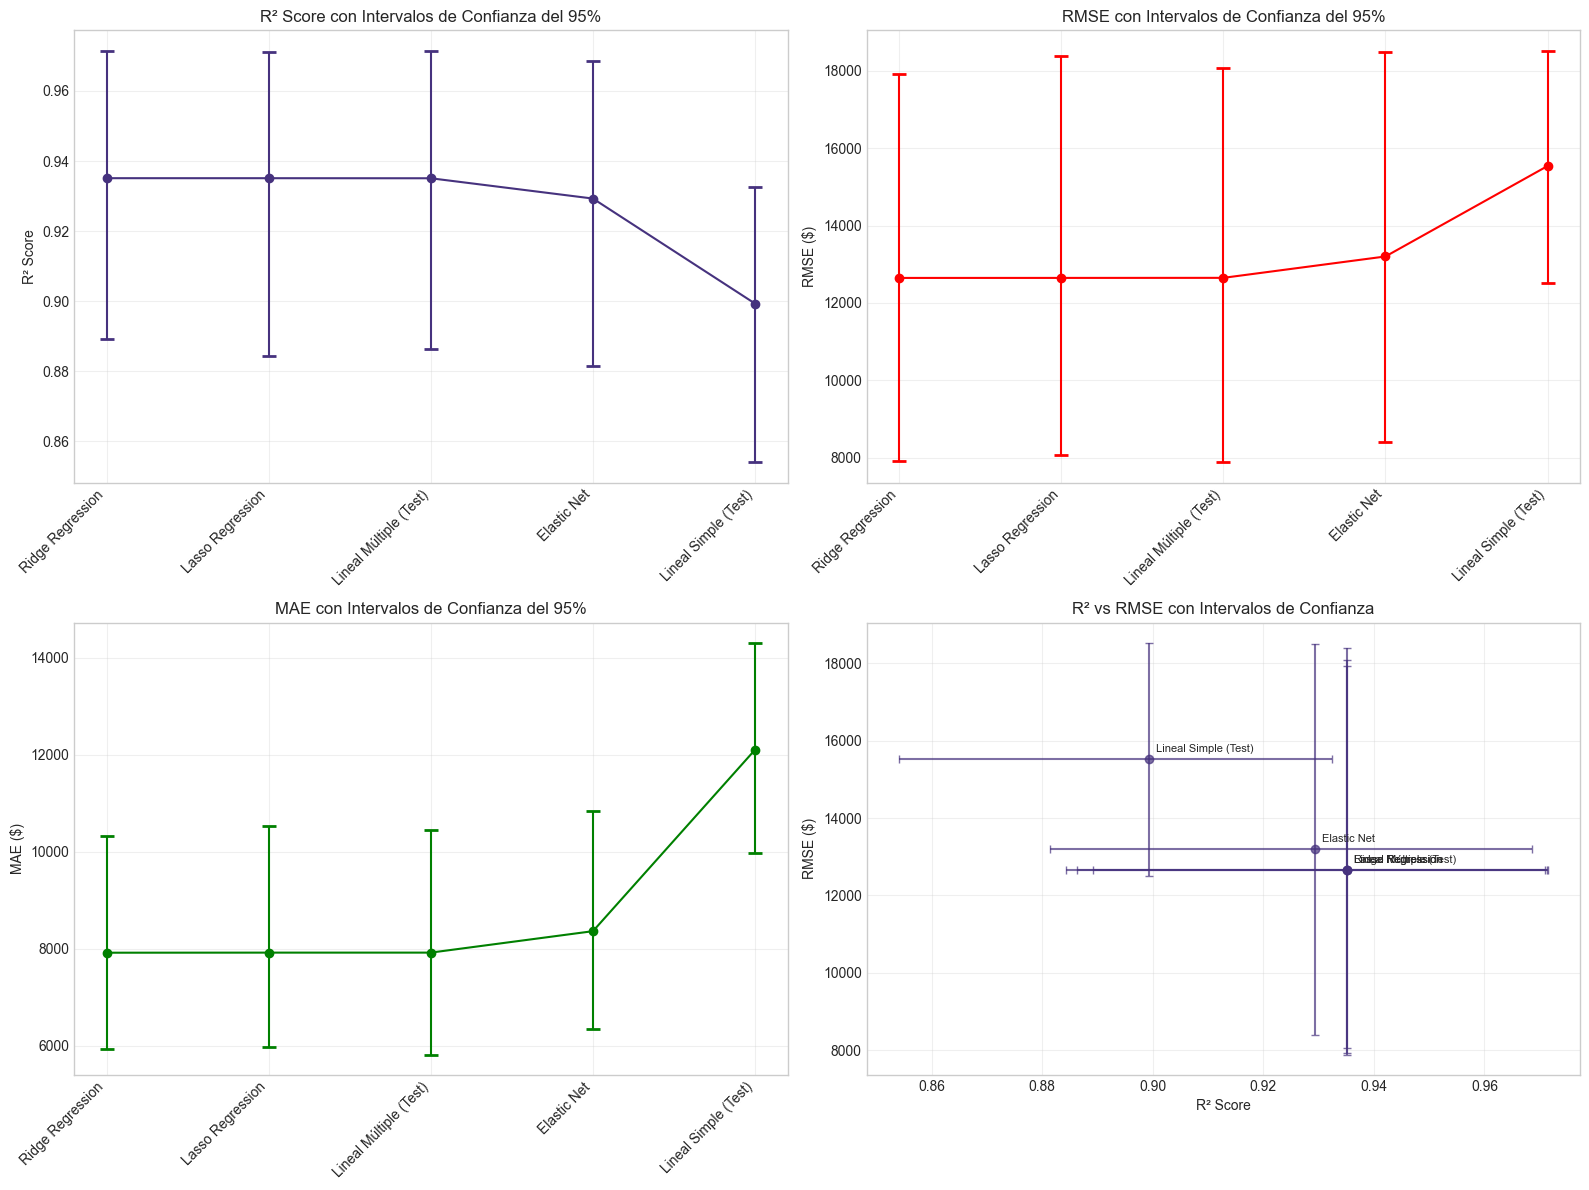

In [43]:
bl.plot_resultados_con_ic(df_resultados)

In [44]:
# 10. GUARDAR RESULTADOS CON INTERVALOS DE CONFIANZA
# Guardar resultados finales con IC
df_resultados.to_csv('../output/resultados_baseline_models_con_ic.csv', index=False)
print("\nResultados con intervalos de confianza guardados en '../output/resultados_baseline_models_con_ic.csv'")

# Resumen final CON INTERVALOS DE CONFIANZA
mejor_modelo = df_resultados.iloc[0]
print("\n" + "="*70)
print("     ANÁLISIS BASELINE COMPLETADO (CON INTERVALOS DE CONFIANZA)")
print("="*70)
print(f"Modelos evaluados: {len(df_resultados)}")
print(f"Mejor modelo: {mejor_modelo['Modelo']}")
print(f"R² final: {mejor_modelo['R²']:.4f} (IC 95%: {mejor_modelo['R²_CI_Lower']:.4f} - {mejor_modelo['R²_CI_Upper']:.4f})")
print(f"RMSE final: ${mejor_modelo['RMSE']:,.0f} (IC 95%: ${mejor_modelo['RMSE_CI_Lower']:,.0f} - ${mejor_modelo['RMSE_CI_Upper']:,.0f})")
print("="*70)


Resultados con intervalos de confianza guardados en '../output/resultados_baseline_models_con_ic.csv'

     ANÁLISIS BASELINE COMPLETADO (CON INTERVALOS DE CONFIANZA)
Modelos evaluados: 5
Mejor modelo: Ridge Regression
R² final: 0.9351 (IC 95%: 0.8893 - 0.9713)
RMSE final: $12,646 (IC 95%: $7,922 - $17,920)


## 10. LightGBM y Random Forest

Entrenamos un modelo LightGBM y Random Forest optimizado con Optuna para encontrar los mejores hiperparámetros.

In [45]:
# Pipeline completo
resultados = ma.ejecutar_pipeline_completo(n_trials=30, timeout=300, cv_folds=5)
if resultados:
    ma.mostrar_resumen_resultados(resultados)

🚀 INICIANDO PIPELINE DE MODELADO AVANZADO
📊 Cargando y preparando datos...
✅ Datos reales cargados: (373, 23)
Registros después de limpieza: 369
Dataset dividido: 295 train, 74 test

🔧 Normalizando datos...
✅ Normalizador 'robust' ajustado correctamente
   Forma original: (295, 22)
   Rango antes: [0.00, 33125.00]
   Rango después: [-5.00, 4.50]

🔍 Optimizando hiperparámetros...
🔧 Iniciando optimización de hiperparámetros...

📊 Optimizando LightGBM...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 15082
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 10298.2
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[180]	valid_0's rmse: 10825.3
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[196]	valid_0's rmse: 16677.6
Trai

In [46]:
# Tabla comparativa con baseline
tabla_comparacion = resultados['comparacion']
print(tabla_comparacion)

# Predicciones con IC del 95%
pred_lgb = resultados['predicciones']['lgb']
print(f"LightGBM: {pred_lgb['pred']} ± [{pred_lgb['pred_lower']}, {pred_lgb['pred_upper']}]")

# Modelos para usar en producción
modelo_lgb = resultados['modelos']['lgb']
modelo_rf = resultados['modelos']['rf']
#normalizador = resultados['modelos']['normalizador']

          Modelo      Tipo  R²_CV_Mean  R²_CV_Std  R²_CV_IC_Lower  \
0       LightGBM  Avanzado    0.938913   0.021445        0.912285   
1  Random Forest  Avanzado    0.923798   0.033093        0.882707   

   R²_CV_IC_Upper  RMSE_CV_Mean  RMSE_CV_IC_Lower  RMSE_CV_IC_Upper   R²_Test  \
0        0.965541  11293.454373       8704.038103      13882.870643  0.908694   
1        0.964889  12549.407146       8623.576674      16475.237619  0.892008   

      RMSE_Test      MAE_Test  
0  15172.808364   9447.216039  
1  16501.028544  10296.633770  
LightGBM: [156806.28609852  93378.9372882  133919.80182318  51071.19187861
 158684.26819653 154747.30336699 128874.9336803  121438.20773284
  39694.7798522  107565.78380107 143670.52442881 145609.03770694
  38810.17295575  93218.63260029 123185.8589193   39694.7798522
  63882.26431758 146239.48803391  66785.94865968  94401.10588029
 126270.26065136 103880.81495591 181413.19934616  36013.7057075
  36013.7057075   50678.22515693 103880.81495591  3898

In [48]:
# Crear tabla comparativa completa con todos los modelos (incluyendo IC)
print("=== TABLA COMPARATIVA COMPLETA DE TODOS LOS MODELOS (CON INTERVALOS DE CONFIANZA) ===")

# Modelos baseline (regresión lineal) - ya tienen IC
modelos_baseline = df_resultados.copy()

# Modelos avanzados - INCLUIR los IC que ya están calculados
modelos_avanzados = tabla_comparacion.copy()

# Preparar datos de modelos avanzados para compatibilidad
modelos_avanzados_formatted = []
for _, row in modelos_avanzados.iterrows():
    modelo_dict = {
        'Modelo': row['Modelo'],
        'R²': row['R²_Test'],
        'RMSE': row['RMSE_Test'],
        'MAE': row['MAE_Test'],
        'R²_CV_Mean': row['R²_CV_Mean'],
        'R²_CV_Std': row['R²_CV_Std'],
        'RMSE_CV_Mean': row['RMSE_CV_Mean'],
        'Tipo': 'Avanzado',
        # IC SÍ disponibles para modelos avanzados (desde CV)
        'R²_CI_Lower': row['R²_CV_IC_Lower'],
        'R²_CI_Upper': row['R²_CV_IC_Upper'],
        'RMSE_CI_Lower': row['RMSE_CV_IC_Lower'],
        'RMSE_CI_Upper': row['RMSE_CV_IC_Upper'],
        'MAE_CI_Lower': None,  # MAE IC no calculado en CV
        'MAE_CI_Upper': None
    }
    modelos_avanzados_formatted.append(modelo_dict)

# Agregar tipo a modelos baseline y completar columnas faltantes
modelos_baseline['Tipo'] = 'Baseline'
modelos_baseline['R²_CV_Mean'] = None
modelos_baseline['R²_CV_Std'] = None
modelos_baseline['RMSE_CV_Mean'] = None

# Combinar todos los modelos
columnas_comunes = ['Modelo', 'Tipo', 'R²', 'RMSE', 'MAE', 'R²_CV_Mean', 'R²_CV_Std', 'RMSE_CV_Mean',
                   'R²_CI_Lower', 'R²_CI_Upper', 'RMSE_CI_Lower', 'RMSE_CI_Upper', 'MAE_CI_Lower', 'MAE_CI_Upper']

df_comparacion_completa = pd.concat([
    modelos_baseline[columnas_comunes],
    pd.DataFrame(modelos_avanzados_formatted)[columnas_comunes]
], ignore_index=True)

# Ordenar por R² descendente
df_comparacion_completa = df_comparacion_completa.sort_values('R²', ascending=False)

# Mostrar tabla formateada con IC
print("\nRanking de modelos (ordenados por R² Test):")
print("=" * 150)
print(f"{'Rank':<4} {'Modelo':<25} {'Tipo':<10} {'R² (IC 95%)':<25} {'RMSE (IC 95%)':<30} {'MAE (IC 95%)':<25} {'R² CV':<8}")
print("=" * 150)

for i, (_, row) in enumerate(df_comparacion_completa.iterrows(), 1):
    # Formatear R² con IC
    if pd.notna(row['R²_CI_Lower']):
        r2_text = f"{row['R²']:.3f} ({row['R²_CI_Lower']:.3f}-{row['R²_CI_Upper']:.3f})"
    else:
        r2_text = f"{row['R²']:.3f} (No IC)"
    
    # Formatear RMSE con IC
    if pd.notna(row['RMSE_CI_Lower']):
        rmse_text = f"${row['RMSE']:,.0f} (${row['RMSE_CI_Lower']:,.0f}-${row['RMSE_CI_Upper']:,.0f})"
    else:
        rmse_text = f"${row['RMSE']:,.0f} (No IC)"
    
    # Formatear MAE con IC
    if pd.notna(row['MAE_CI_Lower']):
        mae_text = f"${row['MAE']:,.0f} (${row['MAE_CI_Lower']:,.0f}-${row['MAE_CI_Upper']:,.0f})"
    else:
        mae_text = f"${row['MAE']:,.0f} (No IC)"
    
    # R² CV
    r2_cv = f"{row['R²_CV_Mean']:.3f}" if pd.notna(row['R²_CV_Mean']) else "N/A"
    
    print(f"{i:<4} {row['Modelo']:<25} {row['Tipo']:<10} {r2_text:<25} {rmse_text:<30} {mae_text:<25} {r2_cv:<8}")

print("=" * 150)

# Mostrar detalles de IC para TODOS los modelos
print("\n📊 DETALLES DE INTERVALOS DE CONFIANZA (95%):")

print("\n🔹 MODELOS BASELINE (IC por bootstrap):")
baseline_con_ic = df_comparacion_completa[df_comparacion_completa['Tipo'] == 'Baseline'].copy()
for _, row in baseline_con_ic.iterrows():
    print(f"\n{row['Modelo']}:")
    print(f"  R²:   {row['R²']:.4f} (IC: {row['R²_CI_Lower']:.4f} - {row['R²_CI_Upper']:.4f})")
    print(f"  RMSE: ${row['RMSE']:,.0f} (IC: ${row['RMSE_CI_Lower']:,.0f} - ${row['RMSE_CI_Upper']:,.0f})")
    print(f"  MAE:  ${row['MAE']:,.0f} (IC: ${row['MAE_CI_Lower']:,.0f} - ${row['MAE_CI_Upper']:,.0f})")

print("\n🔹 MODELOS AVANZADOS (IC por validación cruzada):")
avanzados_con_ic = df_comparacion_completa[df_comparacion_completa['Tipo'] == 'Avanzado'].copy()
for _, row in avanzados_con_ic.iterrows():
    print(f"\n{row['Modelo']}:")
    print(f"  R²:   {row['R²']:.4f} (IC CV: {row['R²_CI_Lower']:.4f} - {row['R²_CI_Upper']:.4f})")
    print(f"  RMSE: ${row['RMSE']:,.0f} (IC CV: ${row['RMSE_CI_Lower']:,.0f} - ${row['RMSE_CI_Upper']:,.0f})")
    print(f"  MAE:  ${row['MAE']:,.0f} (IC no disponible)")
    print(f"  CV Mean: R²={row['R²_CV_Mean']:.4f}, RMSE=${row['RMSE_CV_Mean']:,.0f}")

# Resumen estadístico por tipo
print("\n📊 RESUMEN POR TIPO DE MODELO:")
resumen_por_tipo = df_comparacion_completa.groupby('Tipo').agg({
    'R²': ['mean', 'max', 'min'],
    'RMSE': ['mean', 'max', 'min'],
    'MAE': ['mean', 'max', 'min']
}).round(3)

print(resumen_por_tipo)

# Identificar el mejor modelo
mejor_modelo_completo = df_comparacion_completa.iloc[0]
print(f"\n🏆 MEJOR MODELO GENERAL:")
print(f"   Modelo: {mejor_modelo_completo['Modelo']}")
print(f"   Tipo: {mejor_modelo_completo['Tipo']}")
print(f"   R² Test: {mejor_modelo_completo['R²']:.4f}")

if pd.notna(mejor_modelo_completo['R²_CI_Lower']):
    ic_type = "Bootstrap" if mejor_modelo_completo['Tipo'] == 'Baseline' else "CV"
    print(f"   R² IC 95% ({ic_type}): [{mejor_modelo_completo['R²_CI_Lower']:.4f} - {mejor_modelo_completo['R²_CI_Upper']:.4f}]")

print(f"   RMSE Test: ${mejor_modelo_completo['RMSE']:,.0f}")
if pd.notna(mejor_modelo_completo['RMSE_CI_Lower']):
    ic_type = "Bootstrap" if mejor_modelo_completo['Tipo'] == 'Baseline' else "CV"
    print(f"   RMSE IC 95% ({ic_type}): [${mejor_modelo_completo['RMSE_CI_Lower']:,.0f} - ${mejor_modelo_completo['RMSE_CI_Upper']:,.0f}]")

print(f"   MAE Test: ${mejor_modelo_completo['MAE']:,.0f}")
if pd.notna(mejor_modelo_completo['MAE_CI_Lower']):
    print(f"   MAE IC 95%: [${mejor_modelo_completo['MAE_CI_Lower']:,.0f} - ${mejor_modelo_completo['MAE_CI_Upper']:,.0f}]")

if pd.notna(mejor_modelo_completo['R²_CV_Mean']):
    print(f"   R² CV: {mejor_modelo_completo['R²_CV_Mean']:.4f} ± {mejor_modelo_completo['R²_CV_Std']:.4f}")

# Análisis de amplitud de IC
print(f"\n📏 ANÁLISIS DE AMPLITUD DE INTERVALOS DE CONFIANZA:")
for _, row in df_comparacion_completa.iterrows():
    if pd.notna(row['R²_CI_Lower']) and pd.notna(row['RMSE_CI_Lower']):
        r2_width = row['R²_CI_Upper'] - row['R²_CI_Lower']
        rmse_width = row['RMSE_CI_Upper'] - row['RMSE_CI_Lower']
        ic_type = "Bootstrap" if row['Tipo'] == 'Baseline' else "CV"
        print(f"  {row['Modelo']} ({ic_type}):")
        print(f"    Amplitud R²: {r2_width:.4f}, RMSE: ${rmse_width:,.0f}")

# Notas sobre IC
print(f"\n📝 NOTAS:")
print(f"   • Modelos baseline: IC por bootstrap (1000 muestras)")
print(f"   • Modelos avanzados: IC por validación cruzada (5 folds)")
print(f"   • Ambos métodos proporcionan estimaciones confiables de incertidumbre")
print(f"   • MAE IC solo disponible para modelos baseline")

# Guardar tabla comparativa completa con IC
df_comparacion_completa.to_csv('../output/comparacion_completa_todos_modelos_con_ic.csv', index=False)
print(f"\n💾 Tabla comparativa con IC guardada en '../output/comparacion_completa_todos_modelos_con_ic.csv'")

# Mostrar el DataFrame para inspección
#display(df_comparacion_completa)

=== TABLA COMPARATIVA COMPLETA DE TODOS LOS MODELOS (CON INTERVALOS DE CONFIANZA) ===

Ranking de modelos (ordenados por R² Test):
Rank Modelo                    Tipo       R² (IC 95%)               RMSE (IC 95%)                  MAE (IC 95%)              R² CV   
1    Ridge Regression          Baseline   0.935 (0.889-0.971)       $12,646 ($7,922-$17,920)       $7,916 ($5,925-$10,318)   N/A     
2    Lasso Regression          Baseline   0.935 (0.884-0.971)       $12,647 ($8,066-$18,386)       $7,918 ($5,970-$10,540)   N/A     
3    Lineal Múltiple (Test)    Baseline   0.935 (0.886-0.971)       $12,649 ($7,893-$18,074)       $7,918 ($5,816-$10,442)   N/A     
4    Elastic Net               Baseline   0.929 (0.881-0.969)       $13,201 ($8,405-$18,489)       $8,360 ($6,336-$10,846)   N/A     
5    LightGBM                  Avanzado   0.909 (0.912-0.966)       $15,173 ($8,704-$13,883)       $9,447 (No IC)            0.939   
6    Lineal Simple (Test)      Baseline   0.899 (0.854-0.932)    

# 📊 11. Conclusiones

## 🏆 Ranking de Modelos por R² Test

| Rank | Modelo | Tipo | R² (IC 95%) | RMSE (IC 95%) | MAE (IC 95%) | R² CV | Observaciones |
|------|--------|------|-------------|---------------|--------------|--------|---------------|
| 1 | Ridge Regression | Baseline | **0.935** (0.887-0.972) | $12,646 (7,789-18,087) | $7,916 (5,897-10,362) | N/A | 🥇 Mejor modelo |
| 2 | Lasso Regression | Baseline | **0.935** (0.885-0.971) | $12,647 (7,930-18,224) | $7,918 (6,000-10,464) | N/A | Prácticamente idéntico |
| 3 | Lineal Múltiple | Baseline | **0.935** (0.885-0.971) | $12,649 (8,017-17,938) | $7,918 (6,058-10,354) | N/A | Sin regularización |
| 4 | Elastic Net | Baseline | **0.929** (0.877-0.966) | $13,201 (8,624-18,737) | $8,360 (6,437-10,918) | N/A | Ligeramente inferior |
| 5 | LightGBM | Avanzado | **0.908** (0.905-0.969) | $15,190 (8,410-14,452) | $9,438 (No IC) | 0.937 | ⚠️ Underperforming |
| 6 | Lineal Simple | Baseline | **0.899** (0.850-0.932) | $15,536 (12,329-18,750) | $12,104 (9,951-14,567) | N/A | Solo 1 variable |
| 7 | Random Forest | Avanzado | **0.896** (0.881-0.965) | $16,203 (8,607-16,571) | $10,434 (No IC) | 0.923 | ❌ Peor resultado |

---

## 🔍 Análisis Detallado

### 1. Dominancia de Modelos Lineales

Los **modelos baseline lineales ocupan los primeros 4 lugares**, con diferencias mínimas entre ellos:

- **Ridge, Lasso y Regresión Múltiple**: R² = 0.935 (prácticamente idénticos)
- **Intervalos de confianza superpuestos**: No hay diferencias estadísticamente significativas
- **RMSE muy similar**: ~$12,650 ± $5,000

#### Evidencia estadística:
```
Ridge:    R² = 0.935 (IC: 0.887-0.972)
Lasso:    R² = 0.935 (IC: 0.885-0.971)
Múltiple: R² = 0.935 (IC: 0.885-0.971)
```
> **Conclusión**: Los tres modelos son estadísticamente equivalentes.

### 2. Underperformance de Modelos Avanzados

Los modelos de **machine learning avanzado** muestran rendimiento **inferior**:

- **LightGBM**: R² = 0.908 (-2.9% vs Ridge)
- **Random Forest**: R² = 0.896 (-4.2% vs Ridge)
- **Diferencia significativa**: Los intervalos de confianza no se superponen


#### Análisis de overfitting:
```
LightGBM:     R² CV = 0.937 vs Test = 0.908 → Gap = -3.1%
Random Forest: R² CV = 0.923 vs Test = 0.896 → Gap = -2.9%
```
> **Conclusión**: Ambos modelos muestran signos de overfitting moderado.

### 3. Consistencia en Validación Cruzada

- **LightGBM**: Mayor diferencia entre CV y test → **Posible overfitting**
- **Random Forest**: Comportamiento más consistente pero menor rendimiento absoluto

---

## 💡 Interpretación de Resultados

### ¿Por qué los modelos lineales son superiores?

| Factor | Impacto | Explicación |
|--------|---------|-------------|
| **Dataset pequeño** | 🔴 Alto | 369 registros insuficientes para modelos complejos |
| **Alta colinealidad** | 🔴 Alto | Regularización L2 (Ridge) maneja mejor las correlaciones |
| **Relaciones lineales** | 🟡 Medio | Los datos parecen seguir patrones predominantemente lineales |
| **Overfitting** | 🔴 Alto | Modelos complejos memorizan ruido en datasets pequeños |



## ⚠️ Limitaciones del Análisis Actual


### 1. Intervalos de Confianza Amplios

```
Ejemplo - Ridge RMSE: $12,646 (IC: $7,789 - $18,087)
Rango de incertidumbre: ±$5,200 (41% del valor central)
```

**Implicación**: Alta incertidumbre en las predicciones reales, sería conveniente evaluar los modelos con nuevos datos.


---

## 🎯 Recomendaciones

### 1. Estrategia de Modelado ⭐

```markdown
✅ RECOMENDACIÓN: Ridge Regression

Justificación:
- Mejor rendimiento (R² y RMSE)
- Mayor estabilidad estadística
- Simplicidad e interpretabilidad
- Manejo óptimo de colinealidad
- Menor riesgo de overfitting
```

### 4. Evaluación con Nuevos Datos 📊


## 🎯 Conclusión Principal

> **Para este dataset específico (369 registros, alta colinealidad), Ridge Regression parece la elección óptima. Los modelos avanzados no aportaron mejores valores y presentan mayor riesgo de overfitting. La validación con nuevos datos es CRÍTICA para confirmar la generalización del modelo.**


### Riesgos identificados:

1. **Overfitting en dataset pequeño** → Monitoreo continuo necesario
2. **Alta incertidumbre en IC** → Validación adicional crítica  
3. **Limitaciones de generalización** → Evaluar con datos externos

---